# Exploration of Gender Representation and Tropes in Film on Netflix

## Imports

In [146]:
# import
import pandas as pd
from pandasql import sqldf
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from wordcloud import WordCloud, STOPWORDS
from collections import defaultdict
import numpy as np

import little_mallet_wrapper
from pathlib import Path

from scipy import stats
import scikit_posthocs as sp

In [60]:
# setting the theme for plots
sns.set_theme(style = "whitegrid", font_scale = 1.5, palette = "hls")
unique_genders = ['female', 'male', 'equal', 'none']
# setting a custom palette
seq_pal = sns.color_palette(['#feebe2', '#fbb4b9', '#f768a1', '#ae017e'])
qual_pal = dict(zip(unique_genders, sns.color_palette(['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'])))

In [61]:
# function to get unique values of a column
def getUnique(data):
    unique_values = set()
    for value in data:
        if type(value) is not float:
            values = value.split(", ")
            for i in values:
                unique_values.add(i)
    return list(unique_values)

# function get count of a unique value that is part of a column that needs to be parsed
def getCount(data, token):
    count = 0
    for value in data:
        if value != "":
            values = value.split(", ")
            if token in values:
                count += 1
    return count

# combination of groupby and getCount function
def getCountGB(data, unique_data, group_by, count_by):
    grouped_by = data.groupby([group_by])
    gb_count_dict = dict.fromkeys(grouped_by.groups.keys(), None)
    for element in iter(grouped_by):
        count_dict = dict.fromkeys(unique_data, 0)
        state, frame = element
        for unique_value in unique_data:
            count = getCount(frame[count_by], unique_value)
            count_dict[unique_value] = count
        gb_count_dict[state] = count_dict
    return gb_count_dict

# custom group by function to handle entries that need to be parsed first
def group_by(data, unique_data):
    unique_dict = dict.fromkeys(unique_data, None)
    for unique_value in unique_data:
        index = []
        for j, values in enumerate(data):
            if type(values) is not float:
                if unique_value in values:
                    index.append(j)
        unique_dict[unique_value] = index
    return unique_dict

In [62]:
# importing dataset
films_rating = pd.read_csv("/Users/huongngo/Desktop/PERSONAL PROJECTS/streaming_analysis/data/processed/netflix_films_rating.csv")

In [63]:
# making a separate dataset where averageRating isn't 0
films_rating_pres = films_rating[films_rating['averageRating'] != 0]

In [64]:
# glancing at the dataset
films_rating.head(5)

show_id   type                             title  \
0      s1  Movie              Dick Johnson Is Dead   
1      s7  Movie  My Little Pony: A New Generation   
2      s8  Movie                           Sankofa   
3     s10  Movie                      The Starling   
4     s13  Movie                      Je Suis Karl   

                        director  \
0                Kirsten Johnson   
1  Robert Cullen, José Luis Ucha   
2                   Haile Gerima   
3                 Theodore Melfi   
4            Christian Schwochow   

                                                cast  \
0                                                NaN   
1  Vanessa Hudgens, Kimiko Glenn, James Marsden, ...   
2  Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...   
3  Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...   
4  Luna Wedler, Jannis Niewöhner, Milan Peschel, ...   

                                             country          date_added  \
0                                      United States  September 25, 2021   
1                                                NaN  September 24, 2021   
2  United States, Ghana, Burkina Faso, United Kin...  September 24, 2021   
3                                      United States  September 24, 2021   
4                            Germany, Czech Republic  September 23, 2021   

   month_added  year_added  release_year  ...  \
0            9        2021          2020  ...   
1            9        2021          2021  ...   
2            9        2021          1993  ...   
3            9        2021          2021  ...   
4            9        2021          2021  ...   

                                          listed_in  \
0                                     Documentaries   
1                          Children & Family Movies   
2  Dramas, Independent Movies, International Movies   
3                                  Comedies, Dramas   
4                      Dramas, International Movies   

                                         description     titleId  \
0  As her father nears the end of his life, filmm...  tt11394180   
1  Equestria's divided. But a bright-eyed hero be...  tt10101702   
2  On a photo shoot in Ghana, an American model s...   tt0108041   
3  A woman adjusting to life after a loss contend...   tt5164438   
4  After most of her family is murdered in a terr...   tt9205538   

  averageRating numVotes                                       cast_genders  \
0           7.4   6543.0                                                NaN   
1           6.8   3664.0  ['female', 'female', 'male', 'female', 'female...   
2           7.0    698.0  ['male', 'female', 'female', 'male', 'male', '...   
3           6.3  12681.0  ['female', 'unknown', 'male', 'male', 'male', ...   
4           5.5   1129.0  ['female', 'male', 'male', 'male', 'female', '...   

   cast_majority cast_ratio  director_genders  director_majority  
0           none   0.000000        ['female']             female  
1         female   0.600000  ['male', 'male']               male  
2           male   0.375000          ['male']               male  
3         female   0.454545          ['male']               male  
4           male   0.454545          ['male']               male  

[5 rows x 22 columns]

In [65]:
films_rating.isnull().mean()

show_id              0.000000
type                 0.000000
title                0.000000
director             0.030664
cast                 0.077475
country              0.071766
date_added           0.000000
month_added          0.000000
year_added           0.000000
release_year         0.000000
rating               0.000326
length               0.000000
listed_in            0.000000
description          0.000000
titleId              0.206328
averageRating        0.206328
numVotes             0.206328
cast_genders         0.077475
cast_majority        0.000000
cast_ratio           0.000000
director_genders     0.030664
director_majority    0.000000
dtype: float64

In [66]:
films_rating['averageRating'].fillna(0, inplace = True)

## Exploratory Data Analysis

### How is the gender representation in films on Netflix of all time?

In [67]:
# querying dataframe for count of each majority gender representation
query = """
SELECT cast_majority, COUNT(cast_majority) AS count
FROM films_rating
GROUP BY cast_majority
"""
cast_majority_count = sqldf(query)
cast_majority_count

cast_majority  count
0         equal   1252
1        female    931
2          male   3335
3          none    613

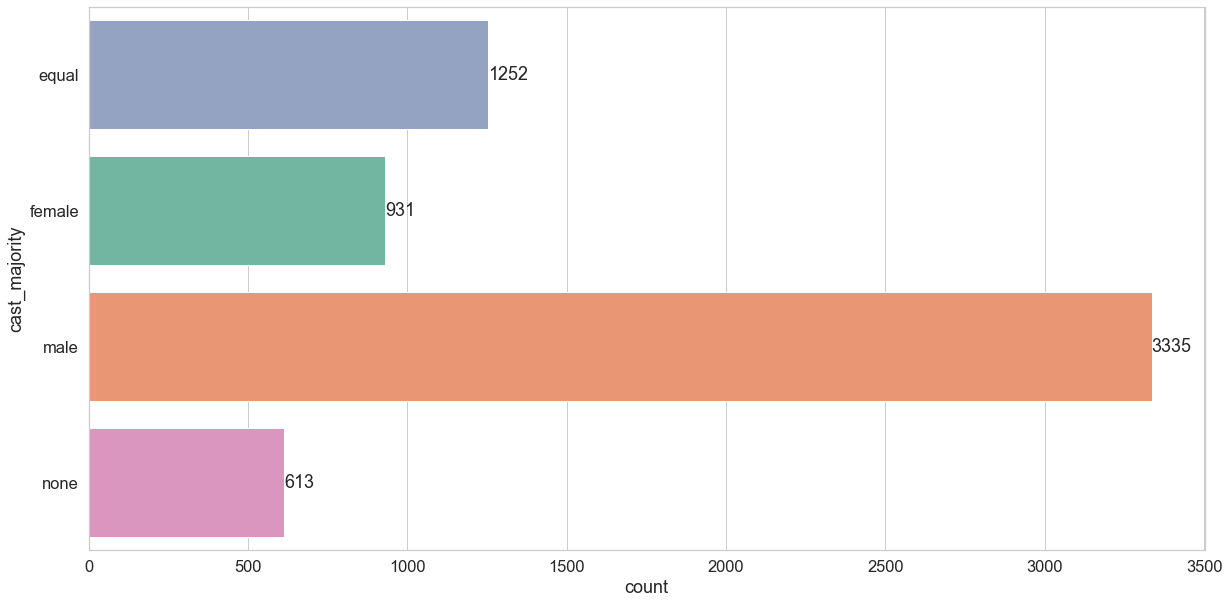

In [68]:
fig, ax = plt.subplots(figsize = (20, 10))
plot = sns.barplot(x = 'count', y = 'cast_majority', data = cast_majority_count, palette = qual_pal)
for i in ax.containers:
    ax.bar_label(i,)

In [69]:
query = """
SELECT director_majority, COUNT(director_majority) AS count
FROM films_rating
GROUP BY director_majority
"""
director_majority_count = sqldf(query)
director_majority_count

director_majority  count
0             equal    200
1            female    566
2              male   3577
3              none   1788

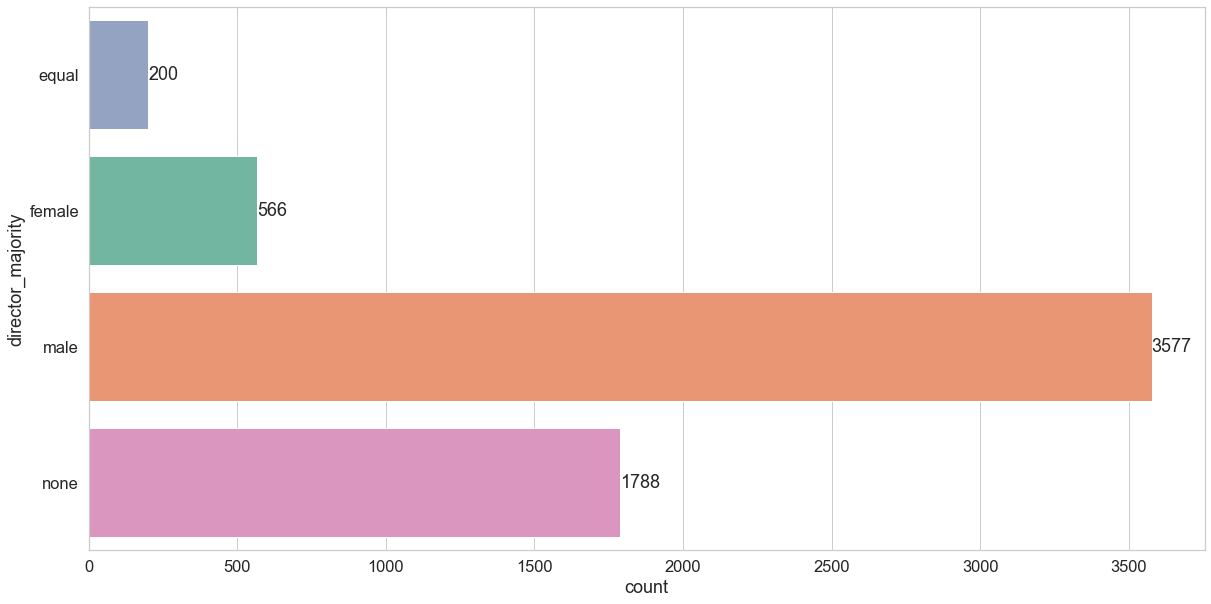

In [70]:
fig, ax = plt.subplots(figsize = (20, 10))
plot = sns.barplot(x = 'count', y = 'director_majority', data = director_majority_count, palette = qual_pal)
for i in ax.containers:
    ax.bar_label(i,)

In [71]:
films_rating[films_rating['cast_ratio'] != 0][['cast_ratio']].describe()

cast_ratio
count  4821.000000
mean      0.376305
std       0.193586
min       0.055556
25%       0.250000
50%       0.352941
75%       0.500000
max       1.000000

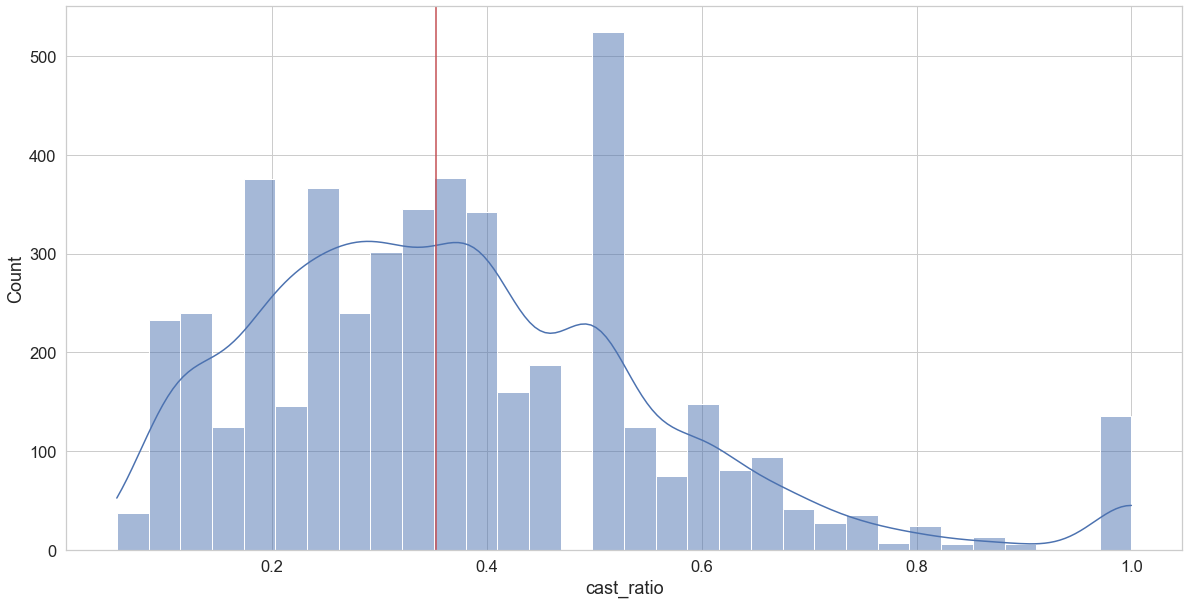

In [72]:
fig, ax = plt.subplots(figsize = (20, 10))
cast_ratio_plt = sns.histplot(data = films_rating[films_rating['cast_ratio'] != 0], x = 'cast_ratio', kde = True, color = 'b')
plt.axvline(x = 0.353, color = "r")

### How has gender representation (cast and directors) in films on Netflix evolved?

In [73]:
query = """
SELECT year_added, cast_majority, COUNT(cast_majority) AS count
FROM films_rating
WHERE year_added >= 2016
GROUP BY year_added, cast_majority
"""

cast_majority_by_year = sqldf(query)
cast_majority_by_year

year_added cast_majority  count
0         2016         equal     78
1         2016        female     24
2         2016          male    113
3         2016          none     38
4         2017         equal    209
5         2017        female    109
6         2017          male    397
7         2017          none    124
8         2018         equal    288
9         2018        female    160
10        2018          male    664
11        2018          none    125
12        2019         equal    262
13        2019        female    230
14        2019          male    790
15        2019          none    142
16        2020         equal    229
17        2020        female    205
18        2020          male    762
19        2020          none     88
20        2021         equal    151
21        2021        female    192
22        2021          male    565
23        2021          none     85

<AxesSubplot:xlabel='year_added', ylabel='count'>

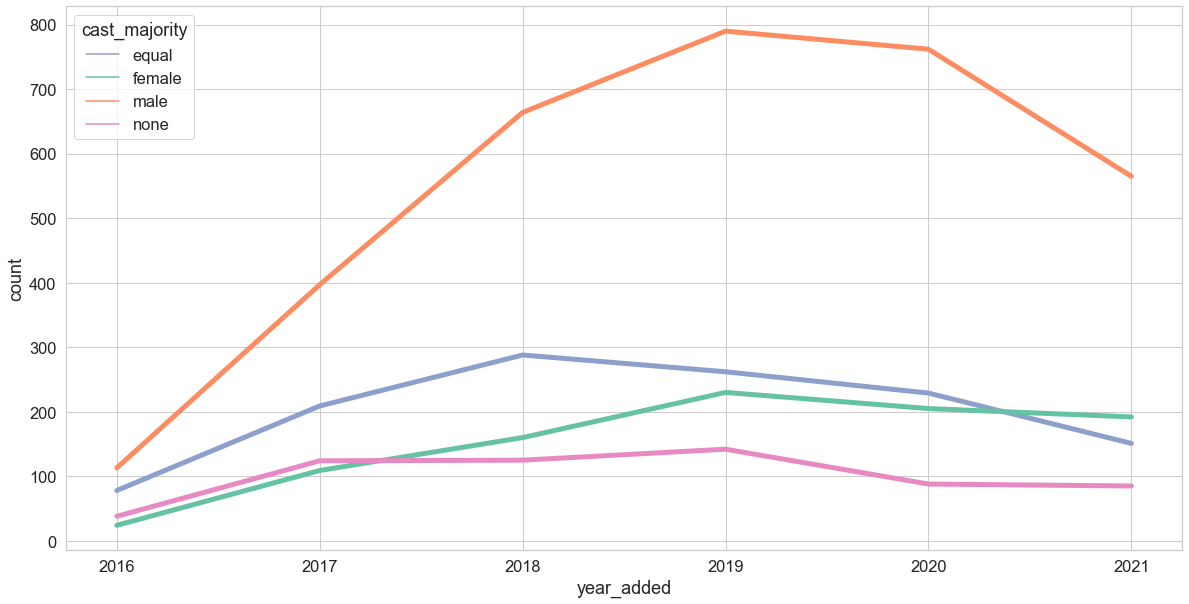

In [74]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year_added', y = 'count', hue = 'cast_majority', data = cast_majority_by_year, lw = 5, palette = qual_pal)

In [75]:
query = """
SELECT year_added, director_majority, COUNT(director_majority) AS count
FROM films_rating
WHERE year_added >= 2016
GROUP BY year_added, director_majority
"""

director_majority_by_year = sqldf(query)
director_majority_by_year

year_added director_majority  count
0         2016             equal     12
1         2016            female     19
2         2016              male    169
3         2016              none     53
4         2017             equal     31
5         2017            female     82
6         2017              male    503
7         2017              none    223
8         2018             equal     43
9         2018            female    100
10        2018              male    636
11        2018              none    458
12        2019             equal     40
13        2019            female    139
14        2019              male    830
15        2019              none    415
16        2020             equal     45
17        2020            female    127
18        2020              male    756
19        2020              none    356
20        2021             equal     23
21        2021            female     89
22        2021              male    610
23        2021              none    271

<AxesSubplot:xlabel='year_added', ylabel='count'>

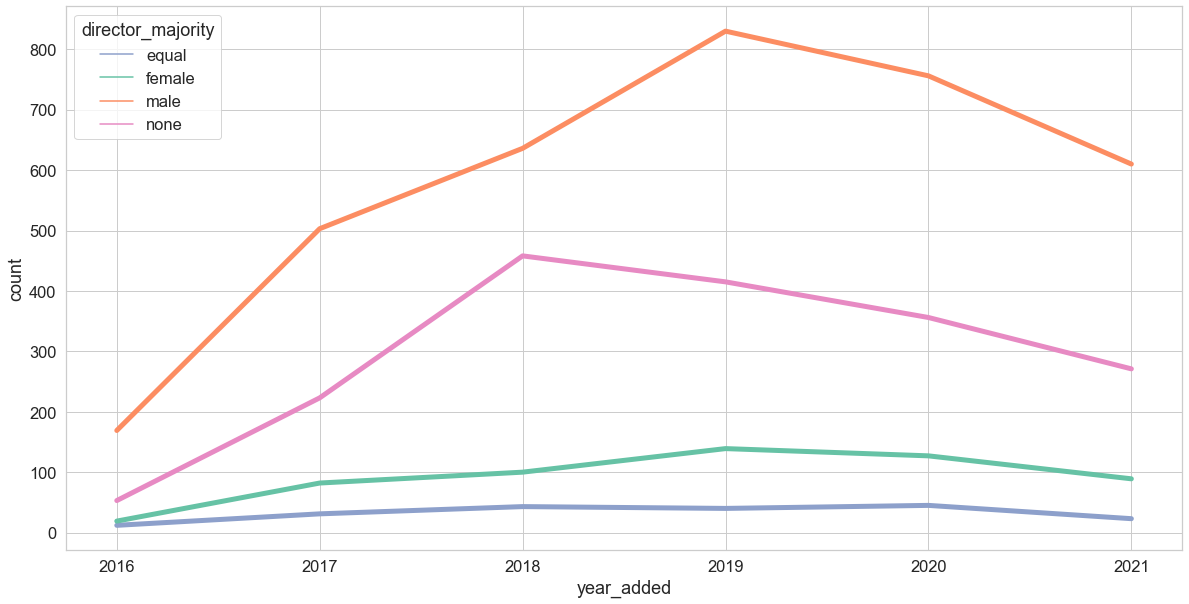

In [76]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year_added', y = 'count', hue = 'director_majority', data = director_majority_by_year, lw = 5, palette = qual_pal)

In [77]:
poo = films_rating.groupby(['year_added'])['year_added', 'cast_ratio']
for state, frame in poo:
    if state == 2020:
        print(frame.head(100))

      year_added  cast_ratio
966         2020    0.200000
967         2020    0.181818
968         2020    0.300000
969         2020    0.300000
970         2020    0.375000
...          ...         ...
1061        2020    0.200000
1062        2020    0.222222
1063        2020    0.222222
1064        2020    0.600000
1065        2020    1.000000

[100 rows x 2 columns]


/var/folders/6g/t90358yn4ynclrp0db92rf1c0000gn/T/ipykernel_57169/3810649358.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  poo = films_rating.groupby(['year_added'])['year_added', 'cast_ratio']


In [78]:
# cast_ratio
temp_list = []
med_cast_ratio = films_rating.groupby(['year_added'])['cast_ratio'].median()
year_index = list(med_cast_ratio.index)
grouped_by_year_ratio_list = list(med_cast_ratio)
for i, value in enumerate(grouped_by_year_ratio_list):
    row_value = (year_index[i], value * 100)
    temp_list.append(row_value)
med_ratio_by_year = pd.DataFrame(temp_list, columns = ['year_added', 'cast_ratio'])
med_ratio_by_year.head(10)

year_added  cast_ratio
0        2008   33.333333
1        2009   29.166667
2        2010    0.000000
3        2011   33.333333
4        2012   22.222222
5        2013   17.500000
6        2014   12.500000
7        2015   21.111111
8        2016   20.000000
9        2017   25.000000

<AxesSubplot:xlabel='year_added', ylabel='cast_ratio'>

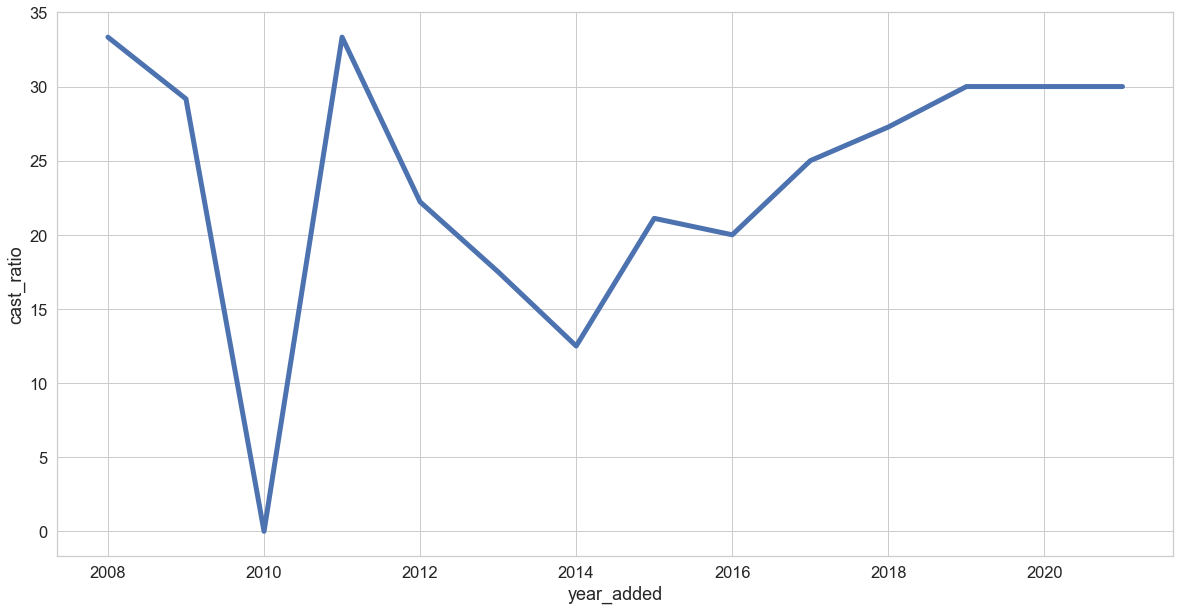

In [79]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year_added', y = 'cast_ratio', data = med_ratio_by_year, lw = 5, color = 'b')

In [80]:
temp_list = []
cast_ratio_year = films_rating[['year_added', 'cast_ratio']]
year_index = sorted(pd.unique(cast_ratio_year['year_added']))
for year in year_index:
    cum = cast_ratio_year[cast_ratio_year['year_added'] <= year]
    ratio = cum['cast_ratio'].median()
    row_value = (year, ratio * 100)
    temp_list.append(row_value)
med_cast_ratio_year = pd.DataFrame(temp_list, columns = ['year', 'cast_ratio'])
med_cast_ratio_year.head(5)

year  cast_ratio
0  2008   33.333333
1  2009   33.333333
2  2010   25.000000
3  2011   33.333333
4  2012   33.333333

<AxesSubplot:xlabel='year', ylabel='cast_ratio'>

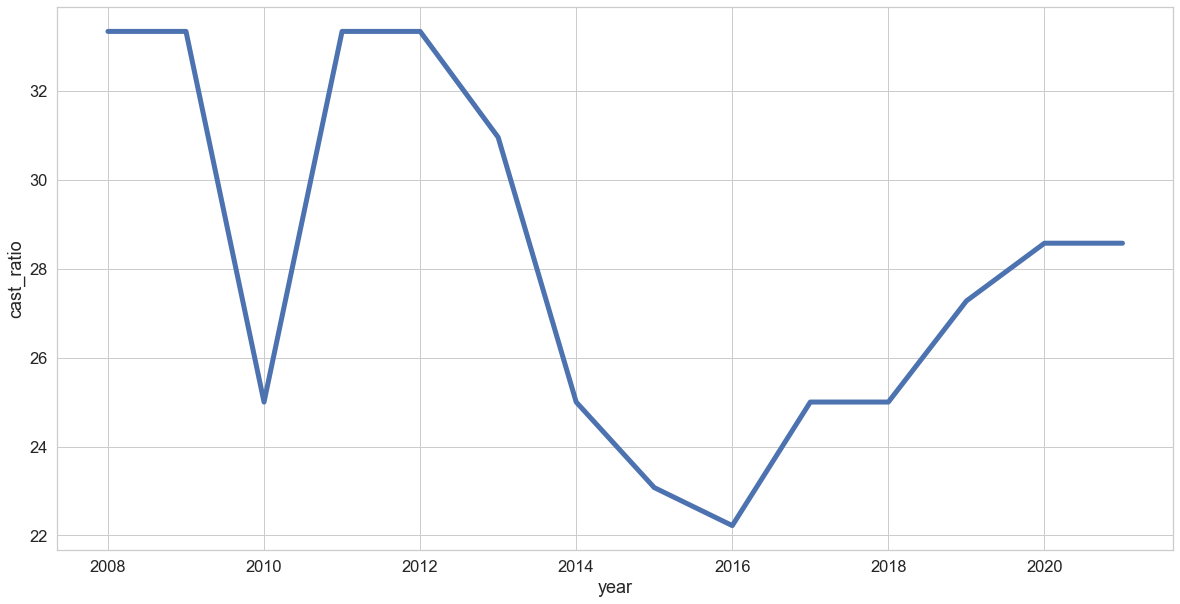

In [81]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year', y = 'cast_ratio', data = med_cast_ratio_year, lw = 5, color = 'b')

### What does gender representation look like in film genres on Netflix?

In [82]:
unique_genres = getUnique(films_rating['listed_in'])
films_by_genre = group_by(films_rating['listed_in'], unique_genres)

In [83]:
total_by_genre = defaultdict(lambda: 0)
for genre, index in films_by_genre.items():
    total_films = len(index)
    total_by_genre[genre] = total_films
total_by_genre

defaultdict(<function __main__.<lambda>()>,
            {'Dramas': 2427,
             'Sports Movies': 219,
             'Romantic Movies': 616,
             'LGBTQ Movies': 102,
             'Movies': 4502,
             'Horror Movies': 357,
             'Classic Movies': 116,
             'Documentaries': 869,
             'International Movies': 2752,
             'Children & Family Movies': 641,
             'Cult Movies': 71,
             'Stand-Up Comedy': 343,
             'Sci-Fi & Fantasy': 243,
             'Comedies': 1674,
             'Anime Features': 71,
             'Thrillers': 577,
             'Independent Movies': 756,
             'Faith & Spirituality': 65,
             'Action & Adventure': 859,
             'Music & Musicals': 375})

In [84]:
# cast majority
count_list = []
for genre in films_by_genre.keys():
    fem_count = 0
    male_count = 0
    equal_count = 0
    cast_majority_by_genre = films_rating['cast_majority'].iloc[films_by_genre[genre]]
    for gender in cast_majority_by_genre:
        if gender == "female":
            fem_count += 1
        elif gender == "male":
            male_count += 1
        elif gender == "equal":
            equal_count += 1
    count_list.append((genre, "female", fem_count))
    count_list.append((genre, "male", male_count))
    count_list.append((genre, "equal", equal_count))
cast_majority_count_by_genre = pd.DataFrame(count_list, columns = ['genre', 'majority_gender', 'count'])
cast_majority_count_by_genre.head(5)

genre majority_gender  count
0         Dramas          female    472
1         Dramas            male   1578
2         Dramas           equal    293
3  Sports Movies          female     13
4  Sports Movies            male     93

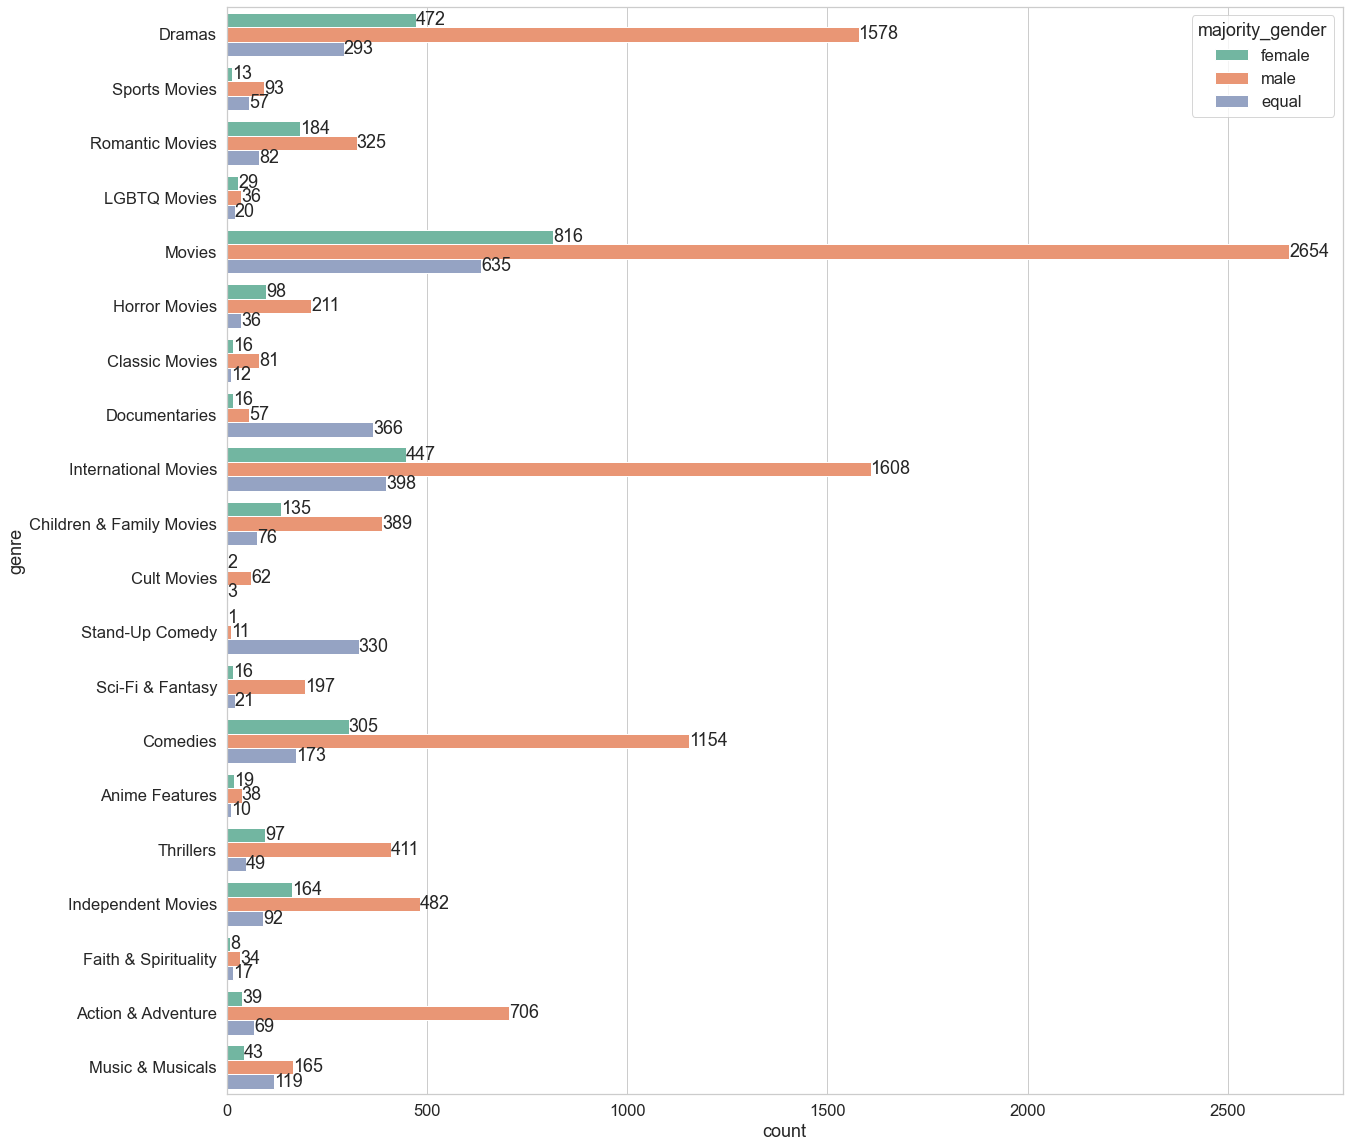

In [85]:
fig, ax = plt.subplots(figsize = (20, 20))
sns.barplot(x = "count", y = "genre", hue = "majority_gender", data = cast_majority_count_by_genre, palette = qual_pal)
for i in ax.containers:
            ax.bar_label(i,)

In [86]:
fem_majority_ratio = []
for genre, cast_majority, count in count_list:
    if cast_majority == 'female':
        fem_majority_ratio.append((genre, count / total_by_genre[genre]))
fem_majority_ratio = sorted(fem_majority_ratio, key = lambda x: x[0])
fem_majority_ratio

[('Action & Adventure', 0.04540162980209546),
 ('Anime Features', 0.2676056338028169),
 ('Children & Family Movies', 0.21060842433697347),
 ('Classic Movies', 0.13793103448275862),
 ('Comedies', 0.1821983273596177),
 ('Cult Movies', 0.028169014084507043),
 ('Documentaries', 0.018411967779056387),
 ('Dramas', 0.19447878038730942),
 ('Faith & Spirituality', 0.12307692307692308),
 ('Horror Movies', 0.27450980392156865),
 ('Independent Movies', 0.21693121693121692),
 ('International Movies', 0.16242732558139536),
 ('LGBTQ Movies', 0.28431372549019607),
 ('Movies', 0.18125277654375832),
 ('Music & Musicals', 0.11466666666666667),
 ('Romantic Movies', 0.2987012987012987),
 ('Sci-Fi & Fantasy', 0.06584362139917696),
 ('Sports Movies', 0.0593607305936073),
 ('Stand-Up Comedy', 0.0029154518950437317),
 ('Thrillers', 0.1681109185441941)]

In [87]:
male_majority_ratio = []
for genre, cast_majority, count in count_list:
    if cast_majority == 'male':
        male_majority_ratio.append((genre, count / total_by_genre[genre]))
male_majority_ratio = sorted(male_majority_ratio, key = lambda x: x[0])
male_majority_ratio

[('Action & Adventure', 0.8218859138533178),
 ('Anime Features', 0.5352112676056338),
 ('Children & Family Movies', 0.6068642745709828),
 ('Classic Movies', 0.6982758620689655),
 ('Comedies', 0.6893667861409797),
 ('Cult Movies', 0.8732394366197183),
 ('Documentaries', 0.06559263521288838),
 ('Dramas', 0.6501854140914709),
 ('Faith & Spirituality', 0.5230769230769231),
 ('Horror Movies', 0.5910364145658263),
 ('Independent Movies', 0.6375661375661376),
 ('International Movies', 0.5843023255813954),
 ('LGBTQ Movies', 0.35294117647058826),
 ('Movies', 0.5895157707685473),
 ('Music & Musicals', 0.44),
 ('Romantic Movies', 0.5275974025974026),
 ('Sci-Fi & Fantasy', 0.8106995884773662),
 ('Sports Movies', 0.4246575342465753),
 ('Stand-Up Comedy', 0.03206997084548105),
 ('Thrillers', 0.7123050259965338)]

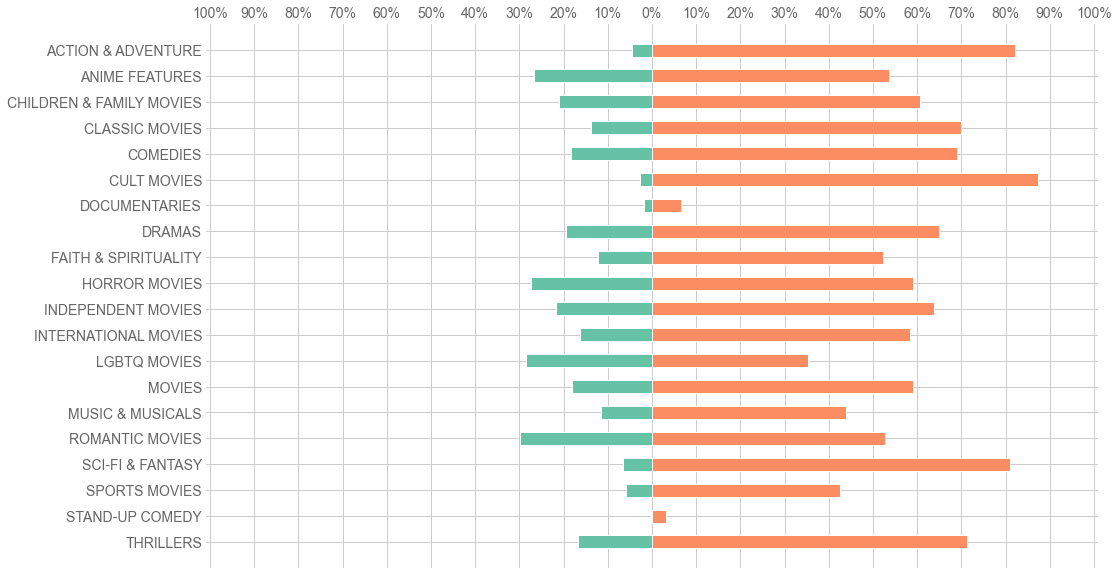

In [88]:
fig, ax = plt.subplots(figsize=(16, 10))
fem_bars = ax.barh(y = [row[0] for row in fem_majority_ratio][::-1], width = [-row[1] for row in fem_majority_ratio][::-1],
                   color = '#66c2a5', zorder = 2, height = 0.5)
male_bars = ax.barh(y = [row[0] for row in male_majority_ratio][::-1], width = [row[1] for row in male_majority_ratio][::-1],
                   color = '#fc8d62', zorder = 2, height = 0.5)

# x axis
plt.xlim(-1.01, 1.01)
plt.xticks(ticks = list([i / 10 for i in range(-10, 11, 1)]), labels =[ str(abs(i) * 10) + '%' for i in range(-10, 11, 1)], \
          fontsize=14, color=(0.4,0.4,0.4))
# put ticks at the top
ax.xaxis.tick_top()

# y axis
plt.ylim(-1, 20)
plt.yticks(ticks=[i[0] for i in male_majority_ratio][::-1], labels=[i[0].upper() for i in male_majority_ratio][::-1], \
           fontsize=14, color=(0.4,0.4,0.4))
           
ax.tick_params(axis=u'both', which=u'both',length=0)

# remove outline box
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# gridlines
plt.grid(True)

plt.show()


In [89]:
# director majority
count_list = []
for genre in films_by_genre.keys():
    fem_count = 0
    male_count = 0
    equal_count = 0
    dir_majority_by_genre = films_rating['director_majority'].iloc[films_by_genre[genre]]
    for gender in dir_majority_by_genre:
        if gender == "female":
            fem_count += 1
        elif gender == "male":
            male_count += 1
        elif gender == "equal":
            equal_count += 1
    count_list.append((genre, fem_count, "female"))
    count_list.append((genre, male_count, "male"))
    count_list.append((genre, equal_count, "equal"))
dir_majority_count_by_genre = pd.DataFrame(count_list, columns = ['genre', 'count', 'majority_gender'])
dir_majority_count_by_genre.head(5)

genre  count majority_gender
0         Dramas    281          female
1         Dramas   1266            male
2         Dramas     34           equal
3  Sports Movies     17          female
4  Sports Movies    149            male

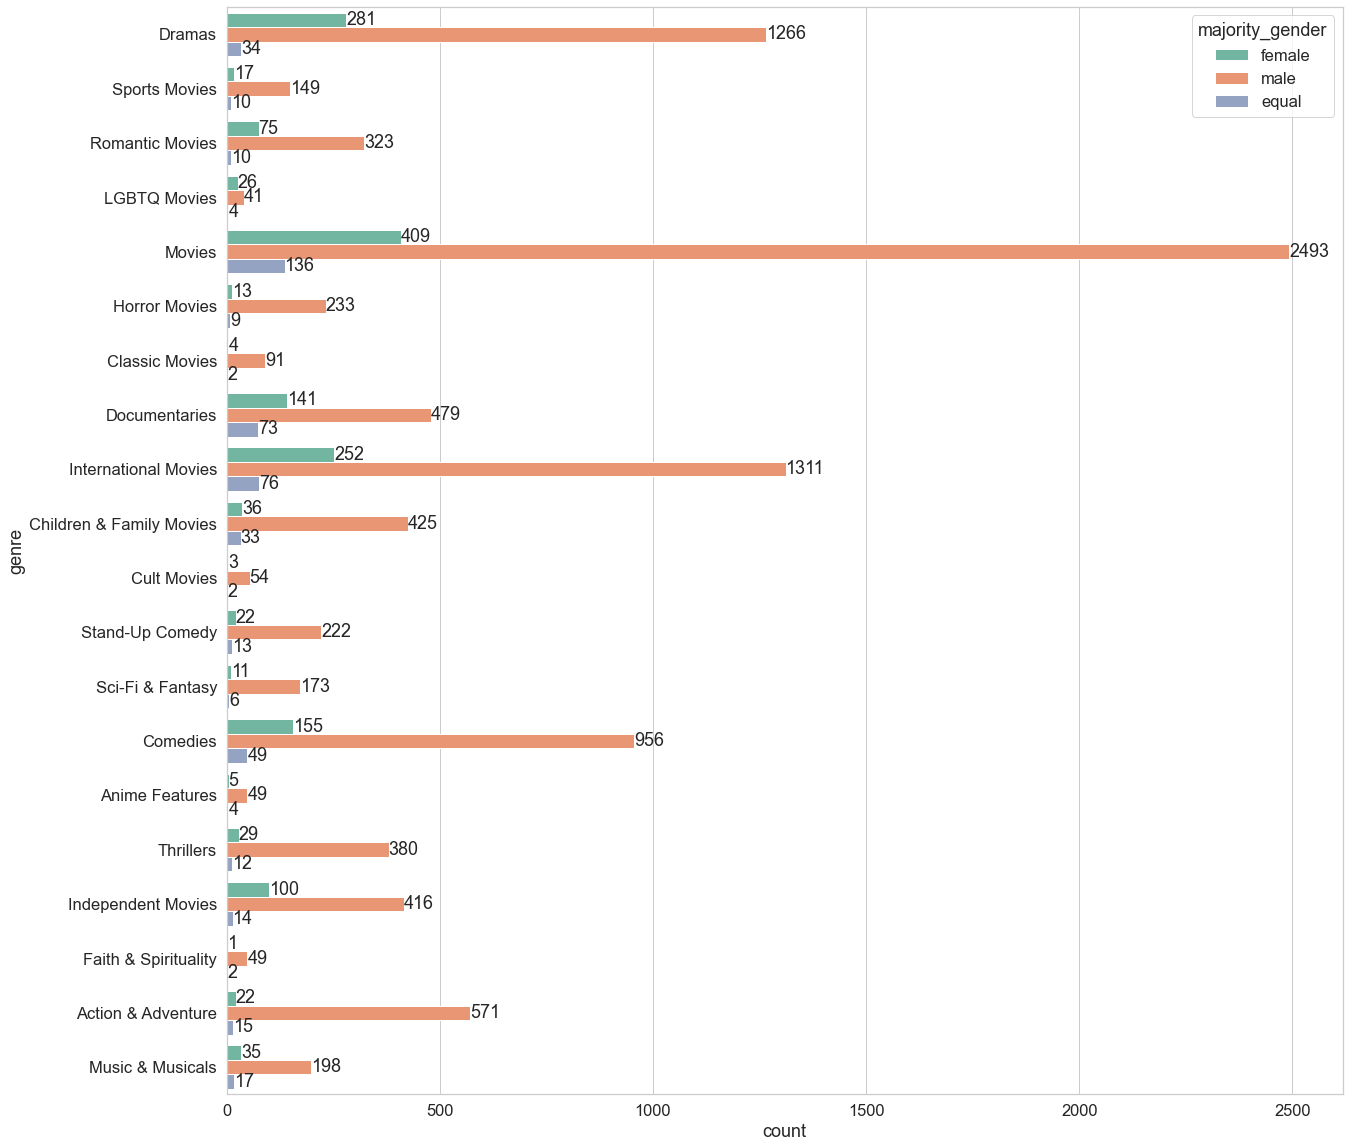

In [90]:
fig, ax = plt.subplots(figsize = (20, 20))
sns.barplot(x = "count", y = "genre", hue = "majority_gender", data = dir_majority_count_by_genre, palette = qual_pal)
for i in ax.containers:
    ax.bar_label(i,)

In [91]:
temp_list = []
for genre in films_by_genre.keys():
    for value in films_rating['cast_ratio'].iloc[films_by_genre[genre]]:
        temp_list.append((genre, value))
cast_ratio_by_genre = pd.DataFrame(temp_list, columns = ['genre', 'cast_ratio'])
cast_ratio_by_genre.head(10)

genre  cast_ratio
0  Dramas    0.375000
1  Dramas    0.454545
2  Dramas    0.454545
3  Dramas    0.428571
4  Dramas    0.300000
5  Dramas    0.200000
6  Dramas    0.000000
7  Dramas    0.200000
8  Dramas    0.400000
9  Dramas    0.181818

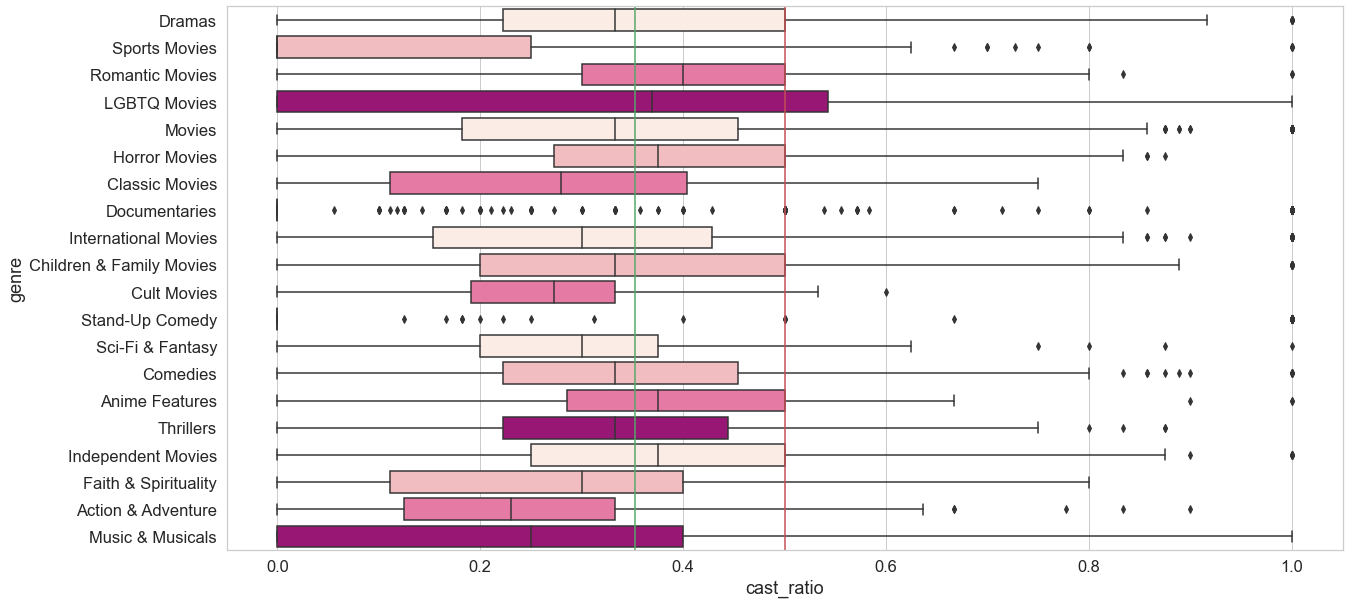

In [92]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.boxplot(x = "cast_ratio", y = "genre", data = cast_ratio_by_genre, palette = seq_pal)
plt.axvline(x = 0.5, color = "r")
plt.axvline(x = 0.353, color = "g")

In [93]:
# ridge plots

### How has gender representation (cast and directors) in film genres on Netflix evolved?

In [94]:
# cast majority
temp_list = []
for genre in films_by_genre.keys():
    grouped_by_genre = films_rating.iloc[films_by_genre[genre]]
    grouped_by_genre = grouped_by_genre[grouped_by_genre['year_added'] >= 2016]
    grouped_by_year_cast = grouped_by_genre.groupby(['year_added', 'cast_majority']).size()
    year_gender_index = list(grouped_by_year_cast.index)
    group_by_year_cast_list = list(grouped_by_year_cast)
    for i, count in enumerate(group_by_year_cast_list):
       row_value = (genre, year_gender_index[i][0], year_gender_index[i][1], count)
       temp_list.append(row_value)
cast_by_genre_year = pd.DataFrame(temp_list, columns = ['genre', 'year_added', 'majority_gender', 'count'])
cast_by_genre_year.head(5)

genre  year_added majority_gender  count
0  Dramas        2016           equal      6
1  Dramas        2016          female     15
2  Dramas        2016            male     44
3  Dramas        2017           equal     30
4  Dramas        2017          female     60

In [95]:
# director majority
temp_list = []
for genre in films_by_genre.keys():
    grouped_by_genre = films_rating.iloc[films_by_genre[genre]]
    grouped_by_genre = grouped_by_genre[grouped_by_genre['year_added'] >= 2016]
    grouped_by_year_dir = grouped_by_genre.groupby(['year_added', 'director_majority']).size()
    year_gender_index = list(grouped_by_year_dir.index)
    group_by_year_dir_list = list(grouped_by_year_dir)
    for i, count in enumerate(group_by_year_dir_list):
       row_value = (genre, year_gender_index[i][0], year_gender_index[i][1], count)
       temp_list.append(row_value)
dir_by_genre_year = pd.DataFrame(temp_list, columns = ['genre', 'year_added', 'majority_gender', 'count'])
dir_by_genre_year.head(5)

genre  year_added majority_gender  count
0  Dramas        2016           equal      1
1  Dramas        2016          female      9
2  Dramas        2016            male     41
3  Dramas        2016            none     14
4  Dramas        2017           equal      6

<AxesSubplot:xlabel='year_added', ylabel='count'>

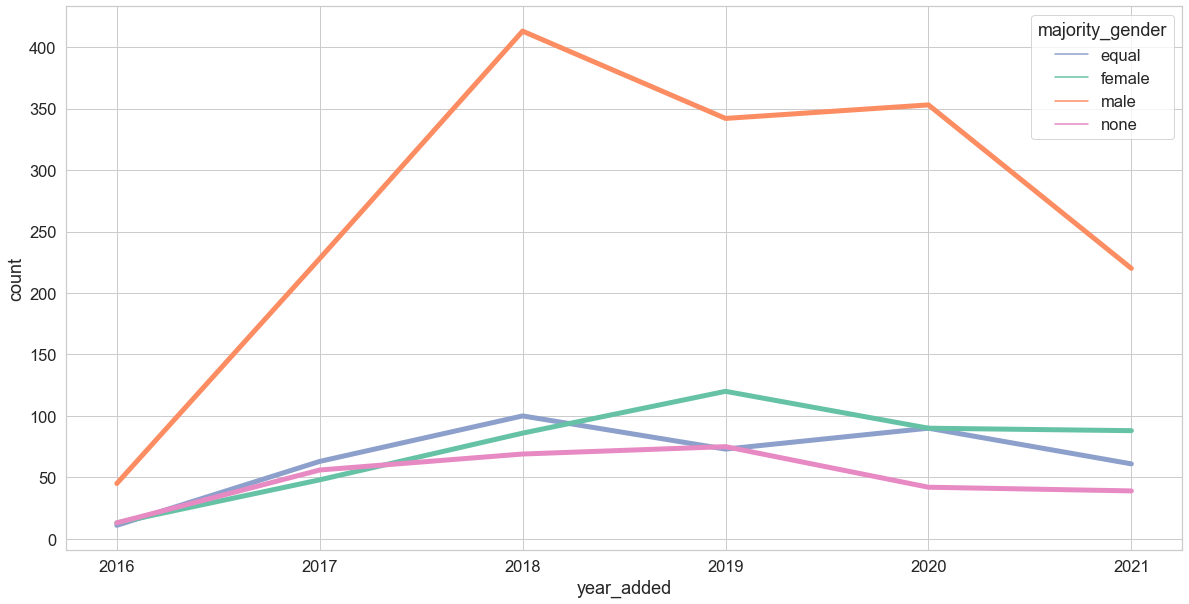

In [96]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year_added', y = 'count', hue = 'majority_gender', data = cast_by_genre_year[cast_by_genre_year['genre'] == "International Movies"], lw = 5, palette = qual_pal)

<AxesSubplot:xlabel='year_added', ylabel='count'>

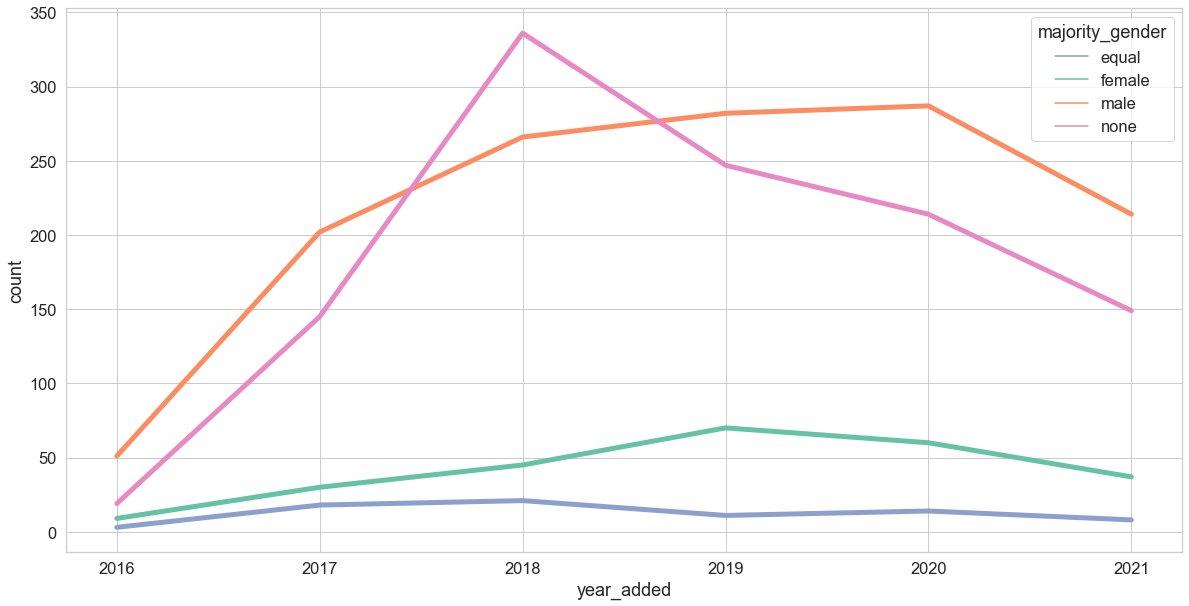

In [97]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year_added', y = 'count', hue = 'majority_gender', data = dir_by_genre_year[dir_by_genre_year['genre'] == "International Movies"], lw = 5, palette = qual_pal)

<AxesSubplot:xlabel='year_added', ylabel='count'>

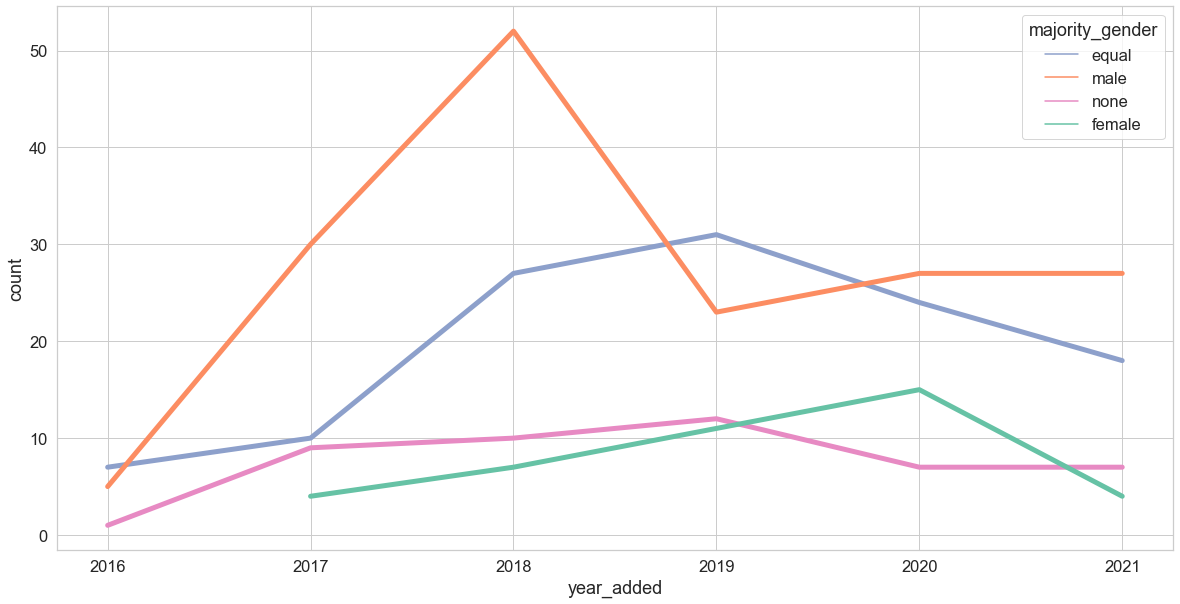

In [98]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year_added', 
            y = 'count', 
            hue = 'majority_gender', 
            data = cast_by_genre_year[cast_by_genre_year['genre'] == "Music & Musicals"], 
            lw = 5, 
            palette = qual_pal)

<AxesSubplot:xlabel='year_added', ylabel='count'>

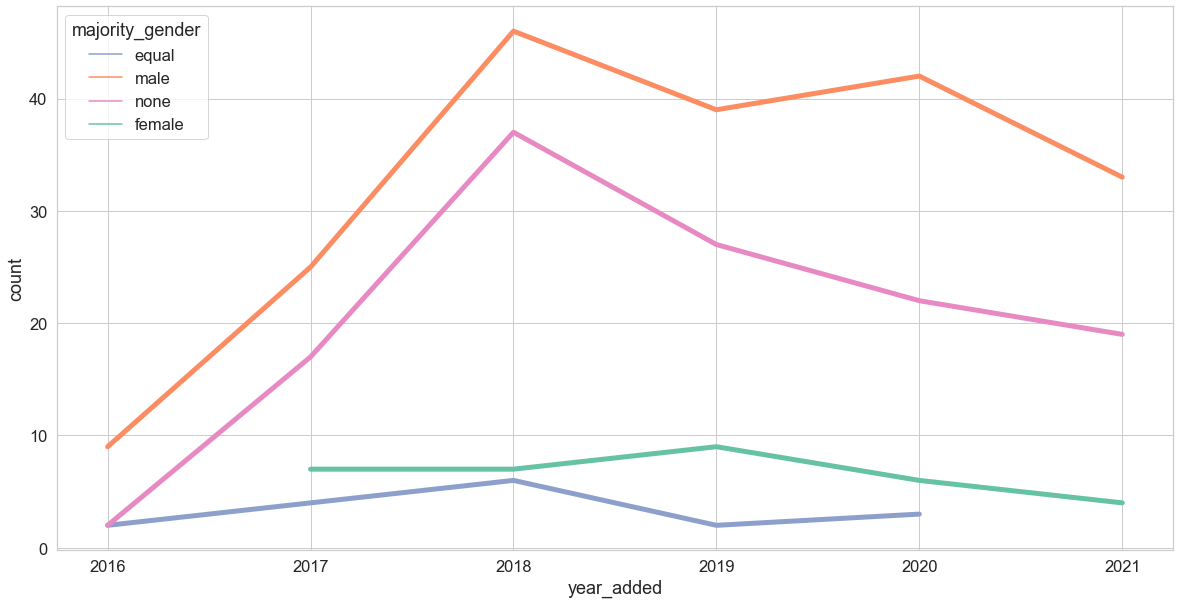

In [99]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year_added', y = 'count', hue = 'majority_gender', data = dir_by_genre_year[dir_by_genre_year['genre'] == "Music & Musicals"], lw = 5, palette = qual_pal)

<AxesSubplot:xlabel='year_added', ylabel='count'>

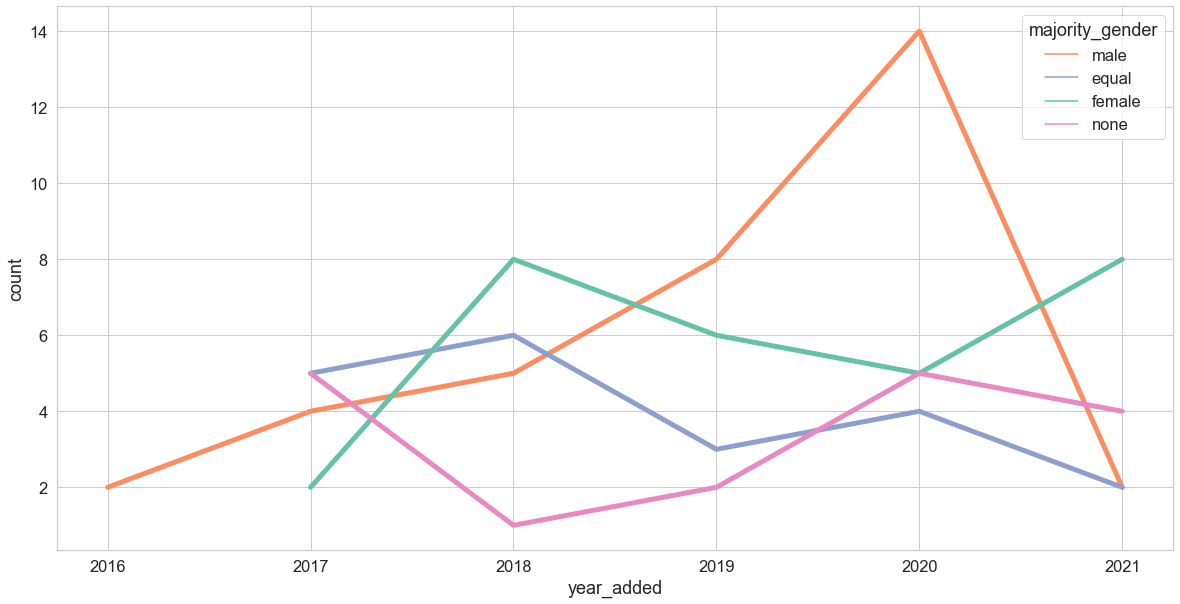

In [100]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year_added', y = 'count', hue = 'majority_gender', data = cast_by_genre_year[cast_by_genre_year['genre'] == "LGBTQ Movies"], lw = 5, palette = qual_pal)

<AxesSubplot:xlabel='year_added', ylabel='count'>

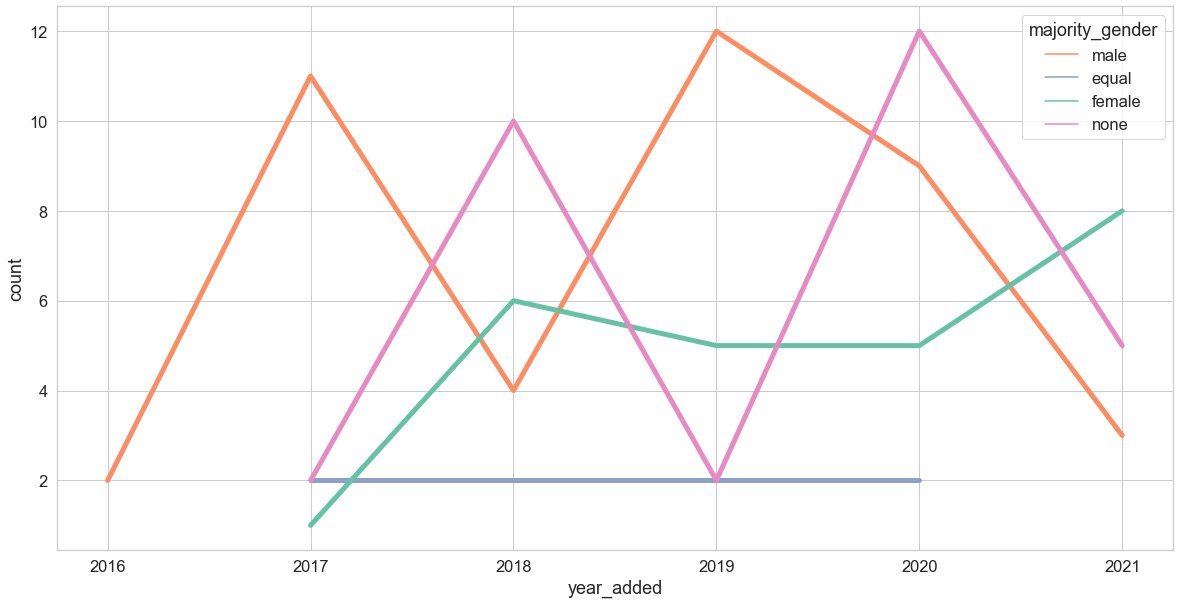

In [101]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year_added', y = 'count', hue = 'majority_gender', data = dir_by_genre_year[dir_by_genre_year['genre'] == "LGBTQ Movies"], lw = 5, palette = qual_pal)

<AxesSubplot:xlabel='year_added', ylabel='count'>

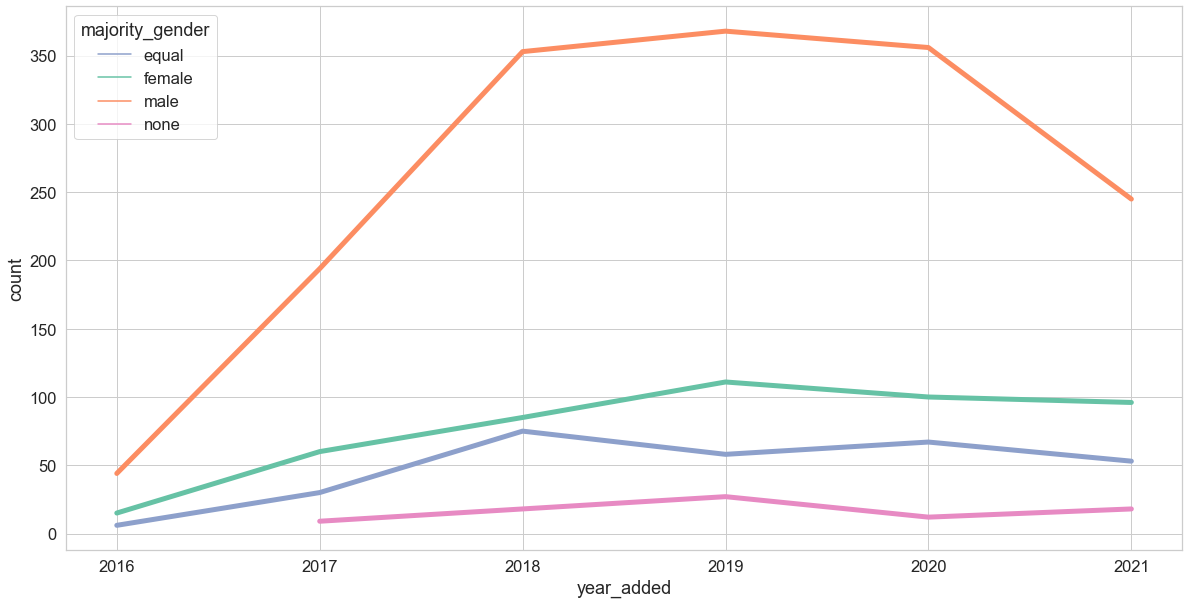

In [102]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year_added', y = 'count', hue = 'majority_gender', data = cast_by_genre_year[cast_by_genre_year['genre'] == "Dramas"], lw = 5, palette = qual_pal)

<AxesSubplot:xlabel='year_added', ylabel='count'>

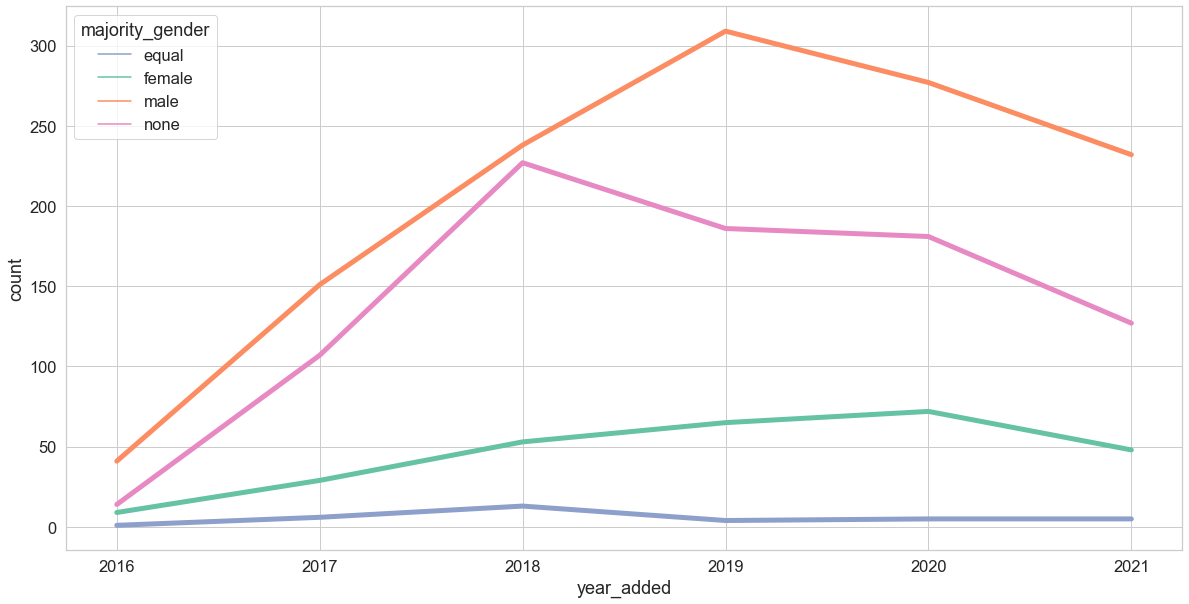

In [103]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year_added', y = 'count', hue = 'majority_gender', data = dir_by_genre_year[dir_by_genre_year['genre'] == "Dramas"], lw = 5, palette = qual_pal)

<AxesSubplot:xlabel='year_added', ylabel='count'>

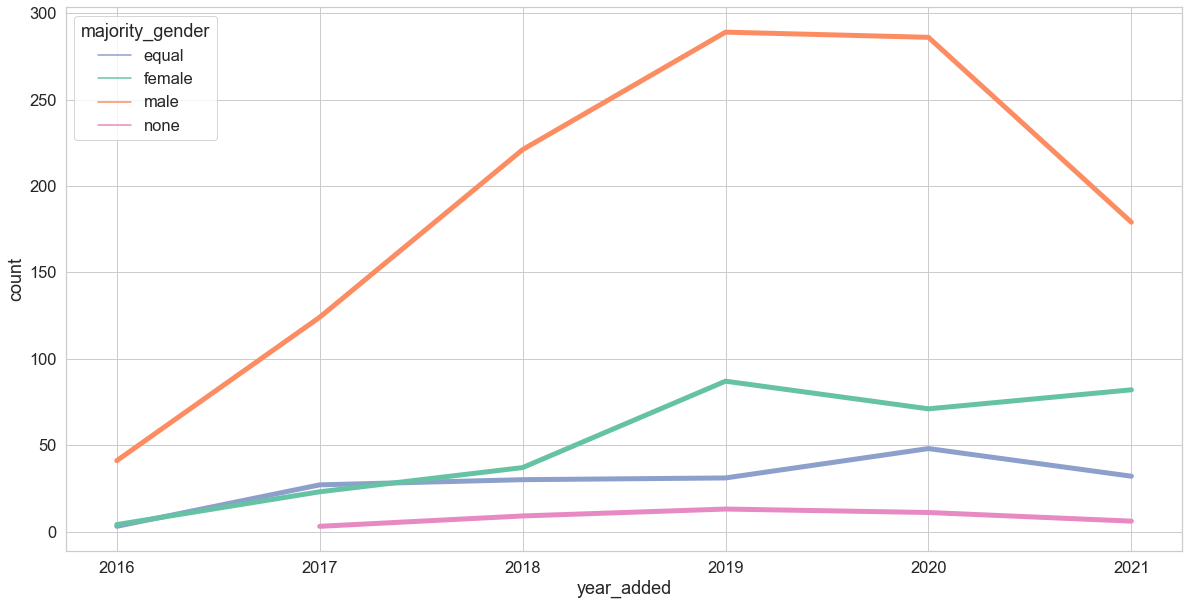

In [104]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year_added', y = 'count', hue = 'majority_gender', data = cast_by_genre_year[cast_by_genre_year['genre'] == "Comedies"], lw = 5, palette = qual_pal)

<AxesSubplot:xlabel='year_added', ylabel='count'>

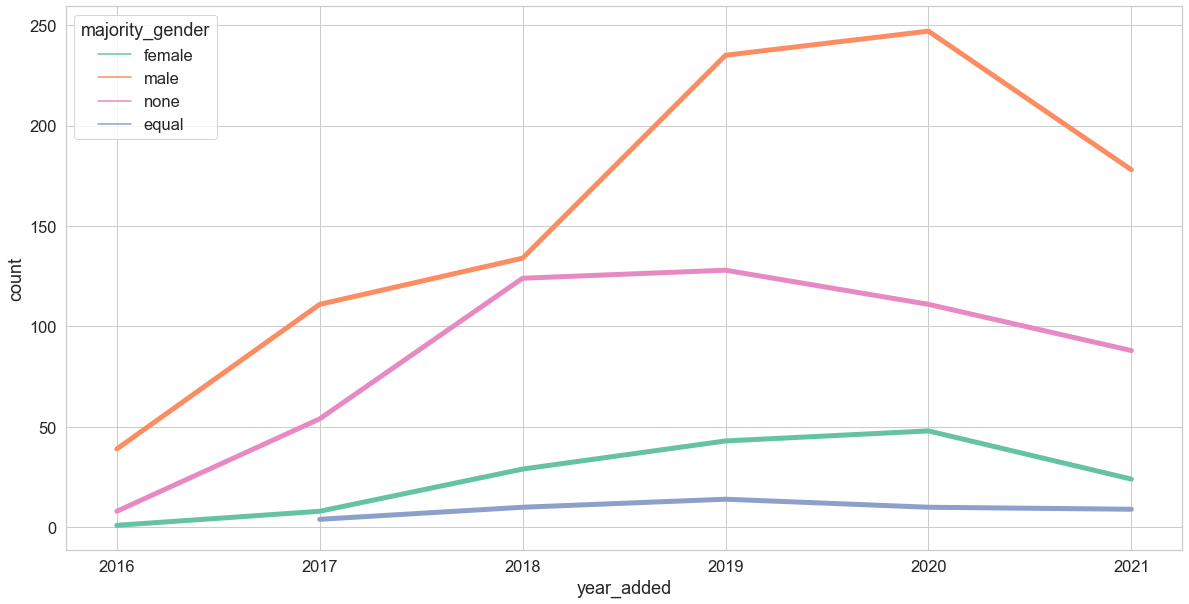

In [105]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year_added', y = 'count', hue = 'majority_gender', data = dir_by_genre_year[dir_by_genre_year['genre'] == "Comedies"], lw = 5, palette = qual_pal)

<AxesSubplot:xlabel='year_added', ylabel='count'>

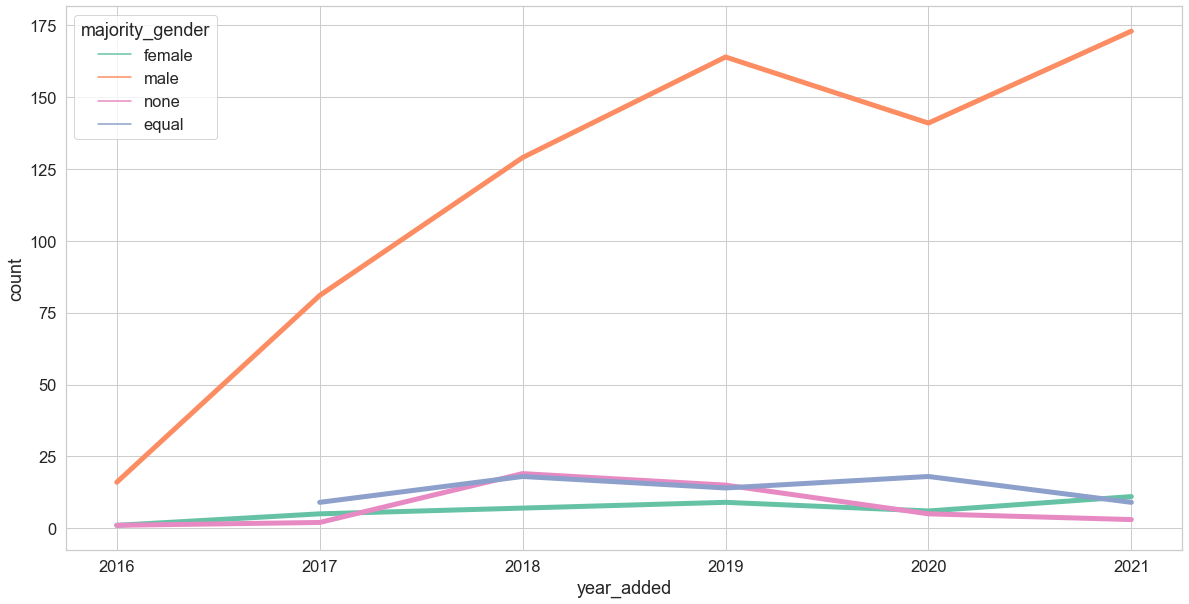

In [106]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year_added', y = 'count', hue = 'majority_gender', data = cast_by_genre_year[cast_by_genre_year['genre'] == "Action & Adventure"], lw = 5, palette = qual_pal)

<AxesSubplot:xlabel='year_added', ylabel='count'>

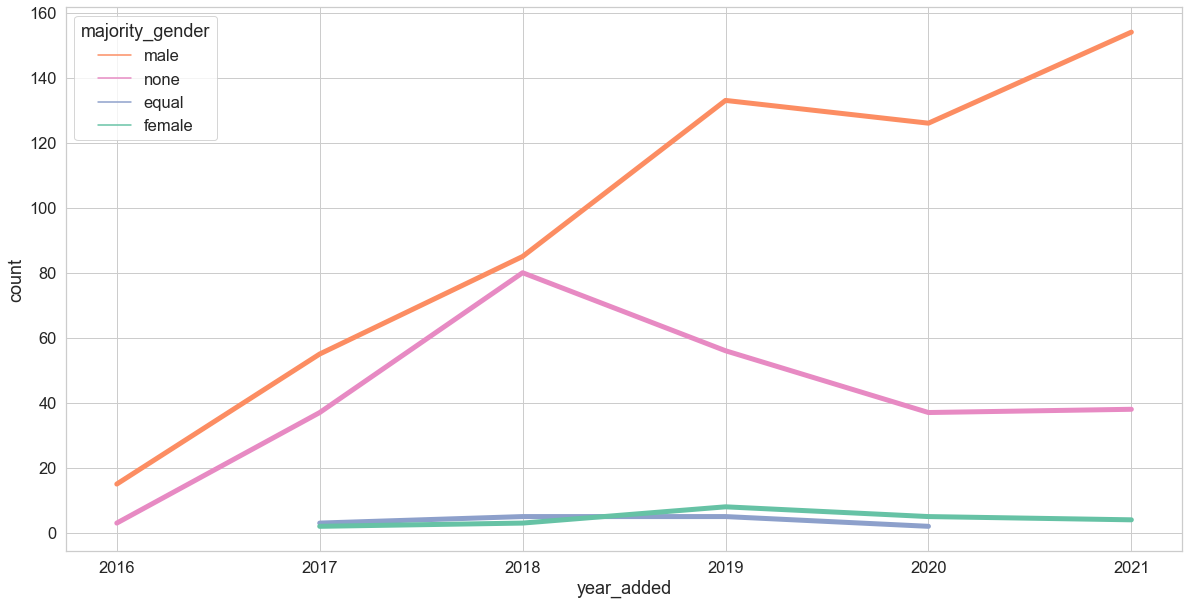

In [107]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year_added', y = 'count', hue = 'majority_gender', data = dir_by_genre_year[dir_by_genre_year['genre'] == "Action & Adventure"], lw = 5, palette = qual_pal)

<AxesSubplot:xlabel='year_added', ylabel='count'>

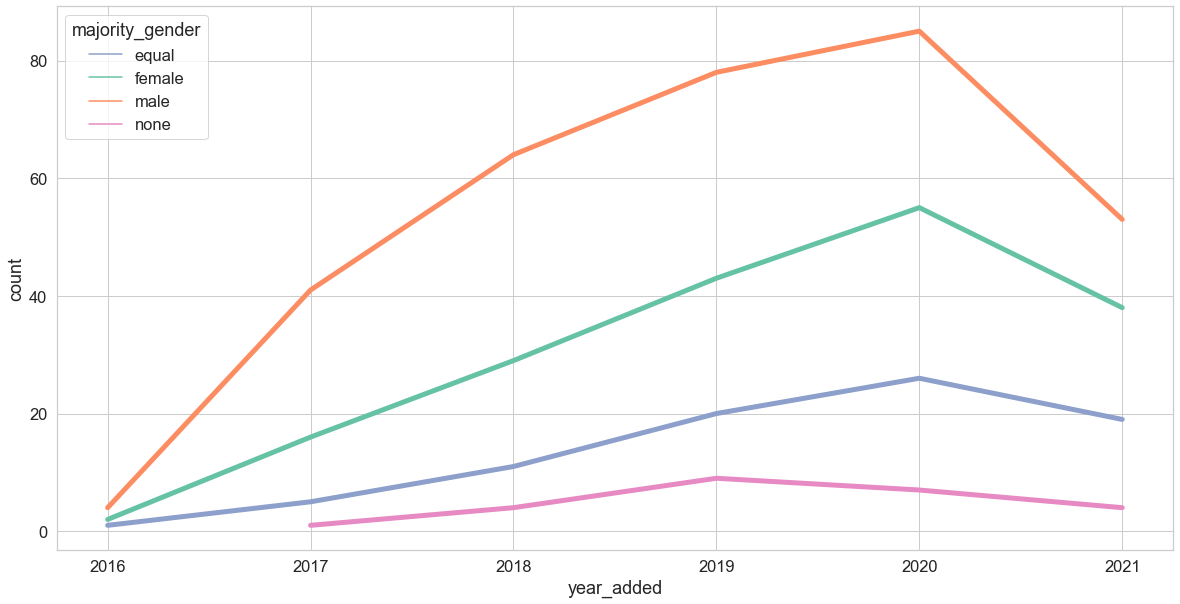

In [108]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year_added', y = 'count', hue = 'majority_gender', data = cast_by_genre_year[cast_by_genre_year['genre'] == "Romantic Movies"], lw = 5, palette = qual_pal)

<AxesSubplot:xlabel='year_added', ylabel='count'>

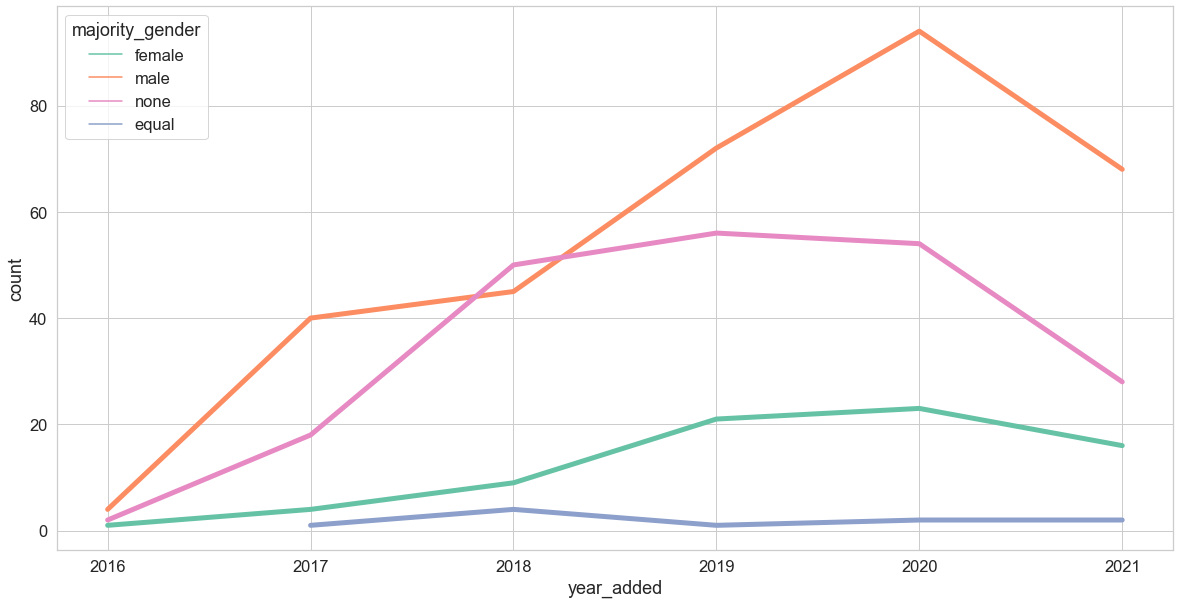

In [109]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year_added', y = 'count', hue = 'majority_gender', data = dir_by_genre_year[dir_by_genre_year['genre'] == "Romantic Movies"], lw = 5, palette = qual_pal)

In [136]:
# cast_ratio
temp_list = []
for genre in films_by_genre.keys():
    grouped_by_genre = films_rating.iloc[films_by_genre[genre]]
    grouped_by_year_ratio = grouped_by_genre.groupby(['year_added'])['cast_ratio'].median()
    year_index = list(grouped_by_year_ratio.index)
    grouped_by_year_ratio_list = list(grouped_by_year_ratio)
    for i, value in enumerate(grouped_by_year_ratio_list):
       row_value = (genre, year_index[i], value * 100)
       temp_list.append(row_value)
ratio_by_genre_year = pd.DataFrame(temp_list, columns = ['genre', 'year_added', 'cast_ratio'])
ratio_by_genre_year.head(5)

genre  year_added  cast_ratio
0  Dramas        2008   33.333333
1  Dramas        2009   41.666667
2  Dramas        2011   33.333333
3  Dramas        2015   40.873016
4  Dramas        2016   33.333333

<AxesSubplot:xlabel='year_added', ylabel='cast_ratio'>

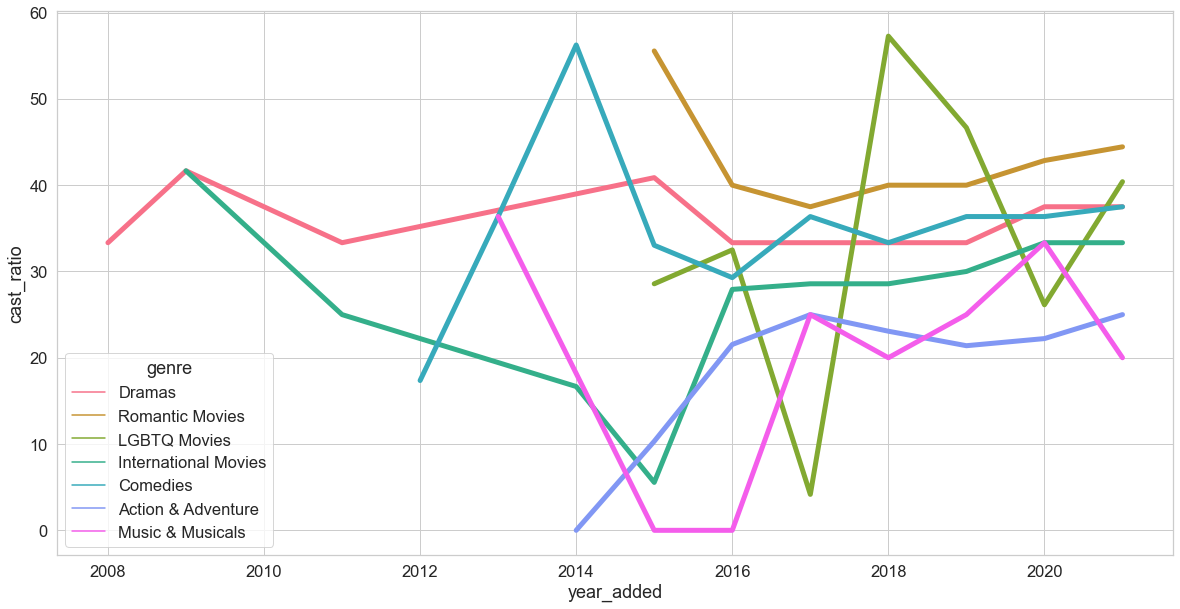

In [137]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year_added', y = 'cast_ratio', hue = 'genre', data = ratio_by_genre_year.loc[ratio_by_genre_year['genre'].isin(['International Movies', 'Music & Musicals', 'LGBTQ Movies', 'Dramas', 'Comedies', 'Action & Adventure', 'Romantic Movies'])], lw = 5)

In [ ]:
temp_list = []
for genre in films_by_genre.keys():
    grouped_by_genre = films_rating.iloc[films_by_genre[genre]]
    year_index = sorted(pd.unique(grouped_by_genre['year_added']))
    for year in year_index:
        grouped_by_genre_cum = grouped_by_genre[grouped_by_genre['year_added'] <= year]
        ratio = grouped_by_genre_cum['cast_ratio'].median()
        row_value = (genre, year, ratio * 100)
        temp_list.append(row_value)
        if genre == 'Music & Musicals':
            print(grouped_by_genre_cum[['year_added', 'cast_ratio']])
ratio_by_genre_year_cum = pd.DataFrame(temp_list, columns = ['genre', 'year', 'cast_ratio'])
ratio_by_genre_year_cum.head(20)

<AxesSubplot:xlabel='year', ylabel='cast_ratio'>

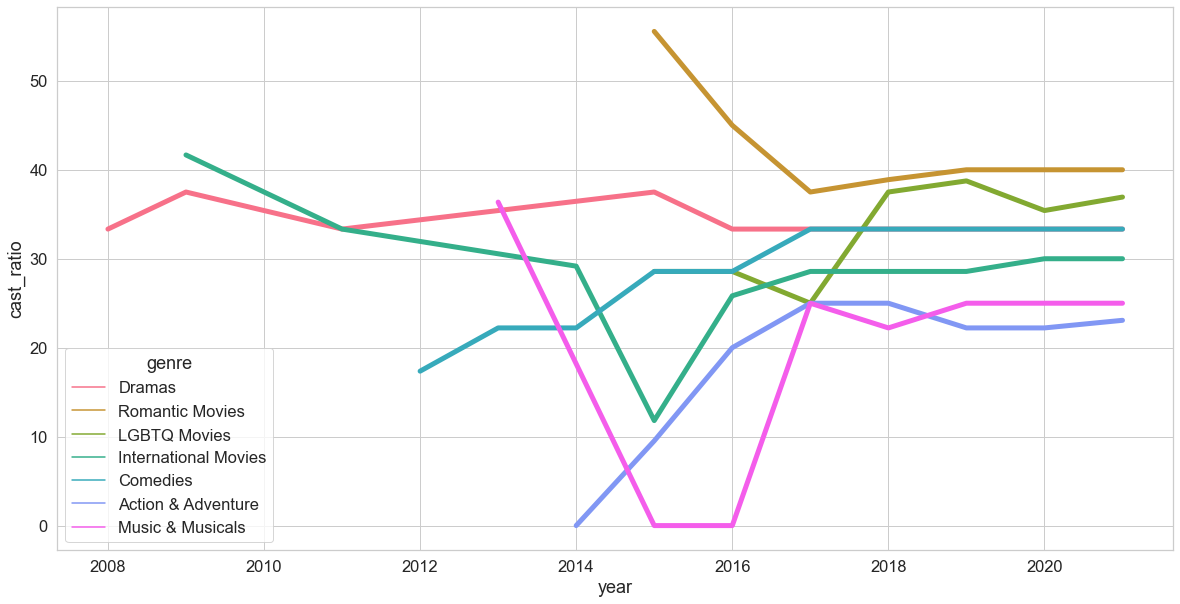

In [141]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year', y = 'cast_ratio', hue = 'genre', data = ratio_by_genre_year_cum.loc[ratio_by_genre_year_cum['genre'].isin(['International Movies', 'Music & Musicals', 'LGBTQ Movies', 'Dramas', 'Comedies', 'Action & Adventure', 'Romantic Movies'])], lw = 5)

### How has gender representation (cast and directors) in films across different countries on Netflix evolved?

In [114]:
unique_countries = getUnique(films_rating['country'])
unique_countries.remove('')
print(unique_countries)

films_by_country = group_by(films_rating['country'], unique_countries)

['Montenegro', 'United Arab Emirates', 'Afghanistan', 'Somalia', 'Kuwait', 'Burkina Faso', 'Hong Kong', 'Panama', 'United Kingdom,', 'New Zealand', 'Pakistan', 'Australia', 'Mexico', 'Taiwan', 'Vatican City', 'Iraq', 'Israel', 'Uruguay', 'Iceland', 'Sri Lanka', 'Romania', 'Ukraine', 'Liechtenstein', 'Netherlands', 'Malaysia', 'Vietnam', 'Brazil', 'Poland,', 'Bangladesh', 'Algeria', 'Ethiopia', 'Kenya', 'Ghana', 'Syria', 'Luxembourg', 'Canada', 'Bermuda', 'Slovakia', 'Cambodia', 'Guatemala', 'Chile', 'Slovenia', 'Jordan', 'Bulgaria', 'Norway', 'Thailand', 'Albania', 'Russia', 'Samoa', 'Zimbabwe', 'Austria', 'South Korea', 'Ireland', 'Angola', 'Denmark', 'Singapore', 'Senegal', 'Mongolia', 'France', 'China', 'Botswana', 'West Germany', 'Kazakhstan', 'Georgia', 'Portugal', 'Finland', 'Namibia', 'Egypt', 'Philippines', 'United Kingdom', 'Malta', 'Cameroon', 'Paraguay', 'Latvia', 'United States', 'South Africa', 'Greece', 'Nepal', 'Saudi Arabia', 'Poland', 'United States,', 'Lebanon', 'Peru

In [115]:
temp_list = []
for country in films_by_country.keys():
    for value in films_rating['cast_ratio'].iloc[films_by_country[country]]:
        temp_list.append((country, value))
cast_ratio_by_country = pd.DataFrame(temp_list, columns = ['country', 'cast_ratio'])
cast_ratio_by_country.head(10)

country  cast_ratio
0            Montenegro    0.400000
1  United Arab Emirates    0.500000
2  United Arab Emirates    0.142857
3  United Arab Emirates    1.000000
4  United Arab Emirates    0.000000
5  United Arab Emirates    0.375000
6  United Arab Emirates    0.416667
7  United Arab Emirates    0.333333
8  United Arab Emirates    0.250000
9  United Arab Emirates    0.400000

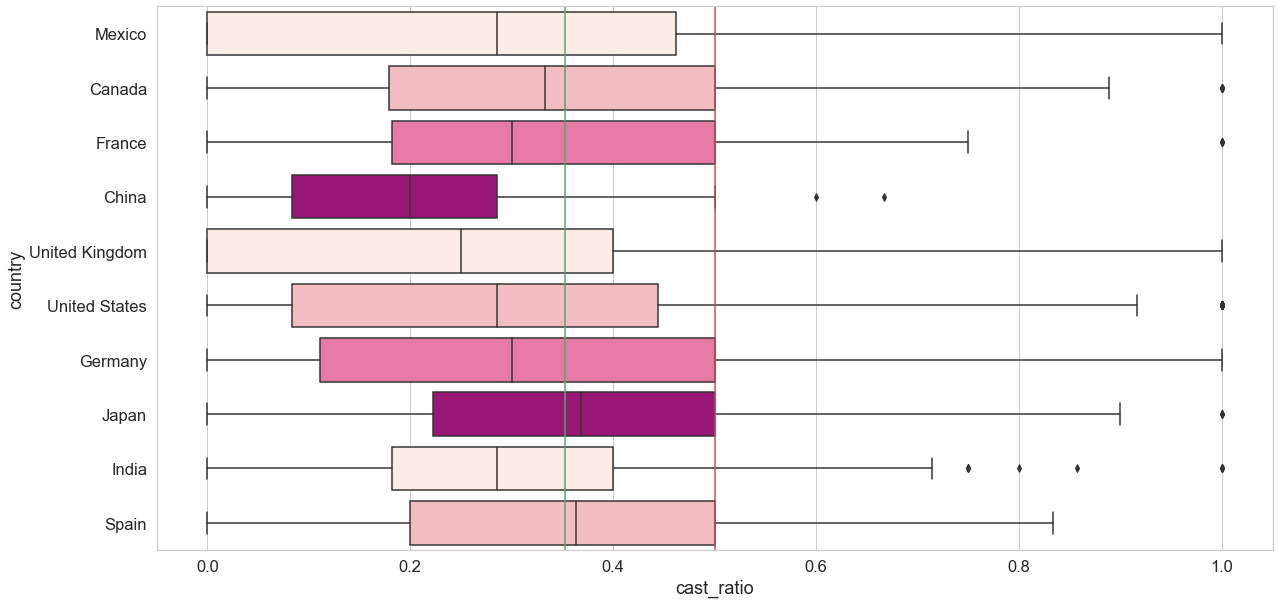

In [116]:
fig, ax = plt.subplots(figsize = (20, 10))
top_10 = ['United States', 'United Kingdom', 'India', 'France', 'Spain', 'Japan', 'Canada', 'Germany', 'China', 'Mexico']
sns.boxplot(x = "cast_ratio", y = "country", data = cast_ratio_by_country[cast_ratio_by_country['country'].isin(top_10)], palette = seq_pal)
plt.axvline(x = 0.5, color = "r")
plt.axvline(x = 0.353, color = "g")

In [117]:
# cast majority
temp_list = []
for country in films_by_country.keys():
    grouped_by_country = films_rating.iloc[films_by_country[country]]
    grouped_by_country = grouped_by_country[grouped_by_country['year_added'] >= 2016]
    grouped_by_year_cast = grouped_by_country.groupby(['year_added', 'cast_majority']).size()
    year_gender_index = list(grouped_by_year_cast.index)
    group_by_year_cast_list = list(grouped_by_year_cast)
    for i, count in enumerate(group_by_year_cast_list):
       row_value = (country, year_gender_index[i][0], year_gender_index[i][1], count)
       temp_list.append(row_value)
cast_by_country_year = pd.DataFrame(temp_list, columns = ['country', 'year_added', 'majority_gender', 'count'])
cast_by_country_year.head(10)

country  year_added majority_gender  count
0            Montenegro        2016            male      1
1  United Arab Emirates        2016            male      1
2  United Arab Emirates        2017           equal      1
3  United Arab Emirates        2017            male      2
4  United Arab Emirates        2017            none      1
5  United Arab Emirates        2018           equal      2
6  United Arab Emirates        2018          female      2
7  United Arab Emirates        2018            male      2
8  United Arab Emirates        2019           equal      2
9  United Arab Emirates        2019            male      6

In [118]:
# director majority
temp_list = []
for country in films_by_country.keys():
    grouped_by_country = films_rating.iloc[films_by_country[country]]
    grouped_by_country = grouped_by_country[grouped_by_country['year_added'] >= 2016]
    grouped_by_year_dir = grouped_by_country.groupby(['year_added', 'director_majority']).size()
    year_gender_index = list(grouped_by_year_dir.index)
    group_by_year_dir_list = list(grouped_by_year_dir)
    for i, count in enumerate(group_by_year_dir_list):
       row_value = (country, year_gender_index[i][0], year_gender_index[i][1], count)
       temp_list.append(row_value)
dir_by_country_year = pd.DataFrame(temp_list, columns = ['country', 'year_added', 'majority_gender', 'count'])
dir_by_country_year.head(10)

country  year_added majority_gender  count
0            Montenegro        2016          female      1
1  United Arab Emirates        2016            male      1
2  United Arab Emirates        2017            male      3
3  United Arab Emirates        2017            none      1
4  United Arab Emirates        2018          female      1
5  United Arab Emirates        2018            male      3
6  United Arab Emirates        2018            none      2
7  United Arab Emirates        2019          female      2
8  United Arab Emirates        2019            male      6
9  United Arab Emirates        2020          female      2

<AxesSubplot:xlabel='year_added', ylabel='count'>

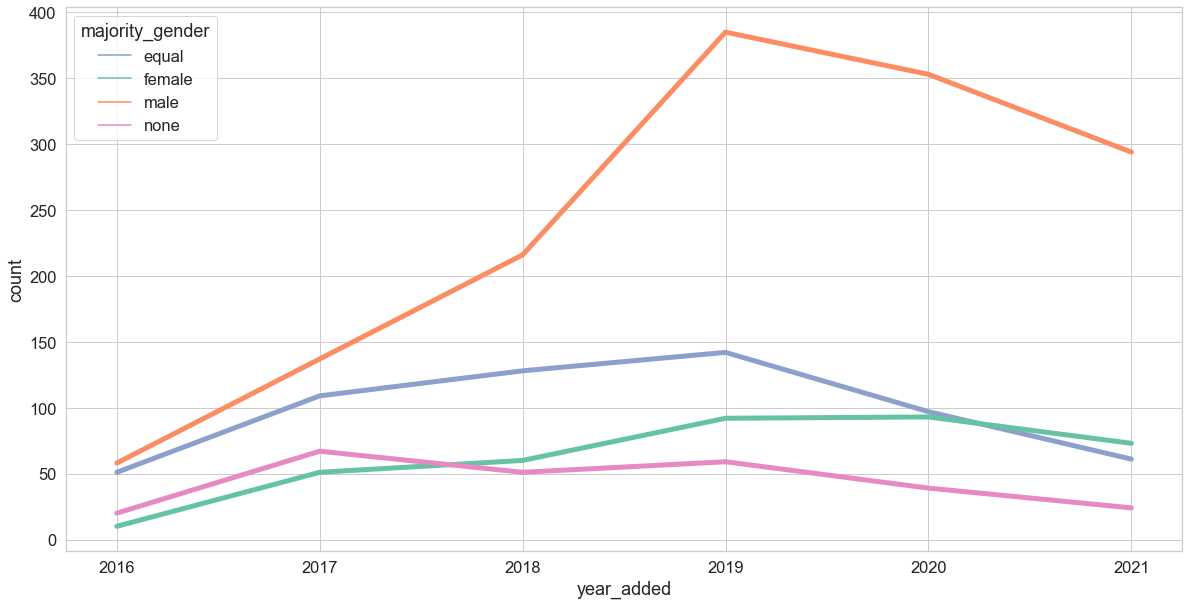

In [119]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year_added', y = 'count', hue = 'majority_gender', data = cast_by_country_year[cast_by_country_year['country'] == "United States"], lw = 5, palette = qual_pal)

<AxesSubplot:xlabel='year_added', ylabel='count'>

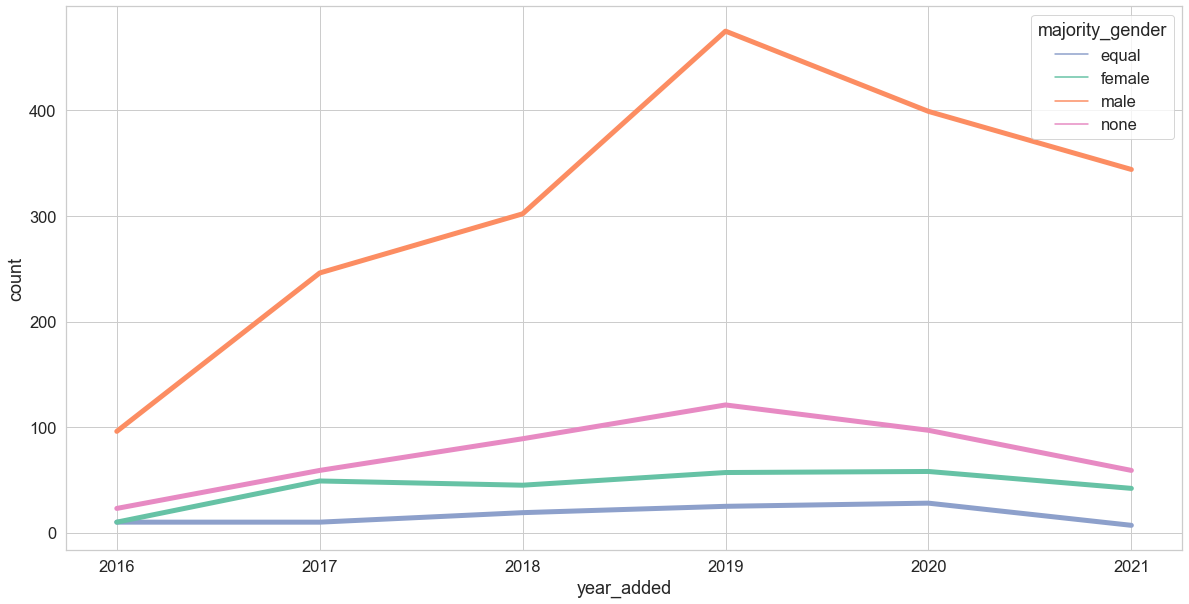

In [120]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year_added', y = 'count', hue = 'majority_gender', data = dir_by_country_year[dir_by_country_year['country'] == "United States"], lw = 5, palette = qual_pal)

<AxesSubplot:xlabel='year_added', ylabel='count'>

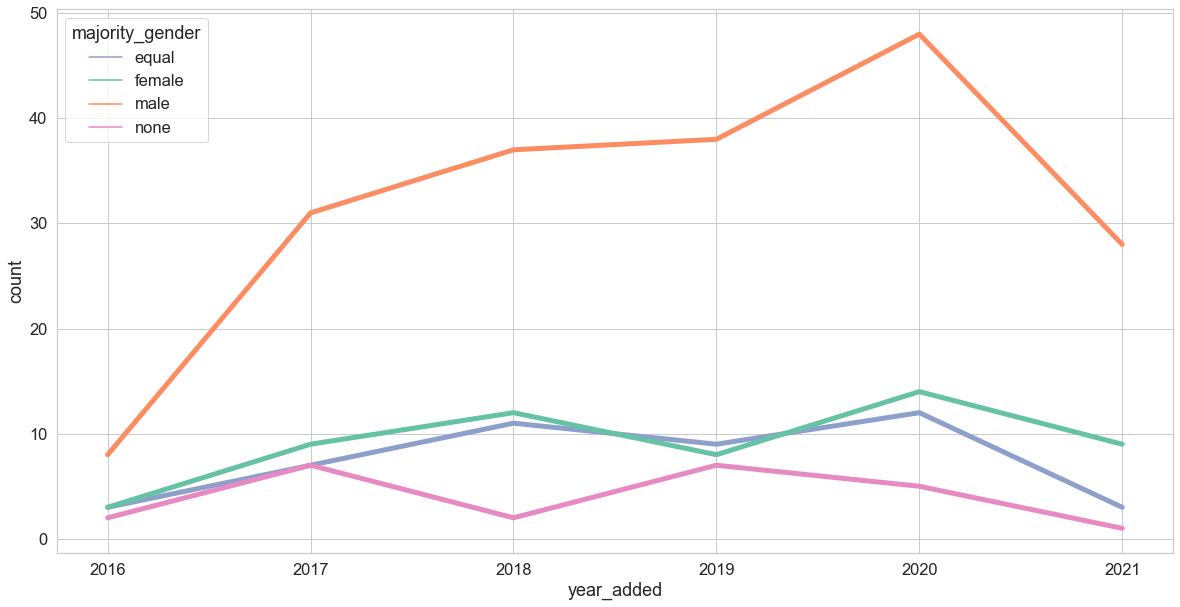

In [121]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year_added', y = 'count', hue = 'majority_gender', data = cast_by_country_year[cast_by_country_year['country'] == "Canada"], lw = 5, palette = qual_pal)

<AxesSubplot:xlabel='year_added', ylabel='count'>

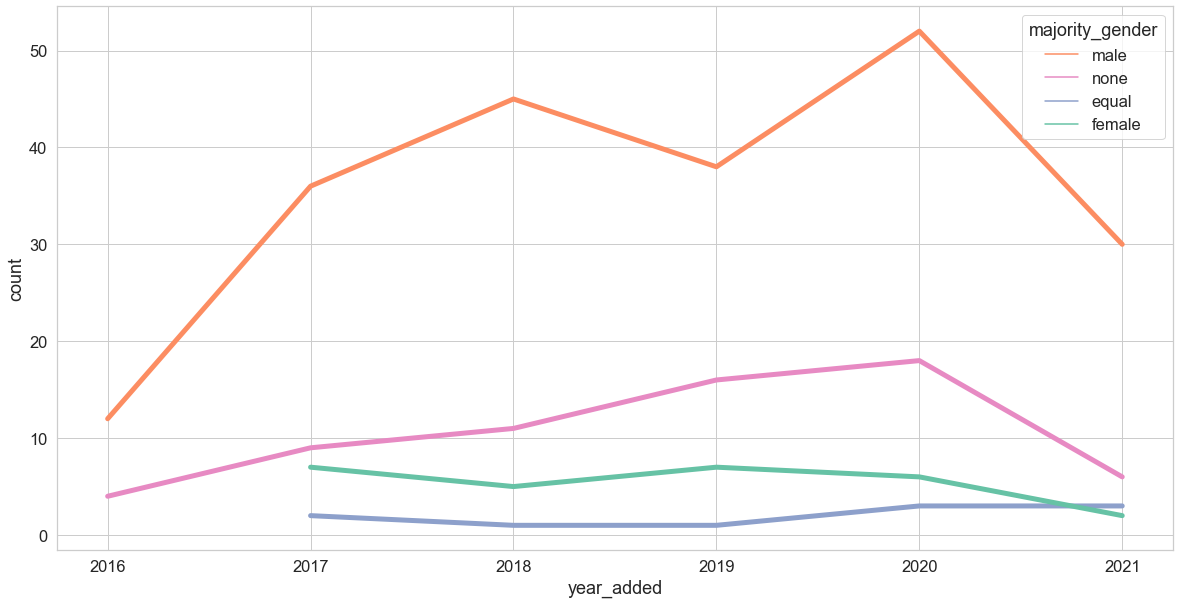

In [122]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year_added', y = 'count', hue = 'majority_gender', data = dir_by_country_year[dir_by_country_year['country'] == "Canada"], lw = 5, palette = qual_pal)

<AxesSubplot:xlabel='year_added', ylabel='count'>

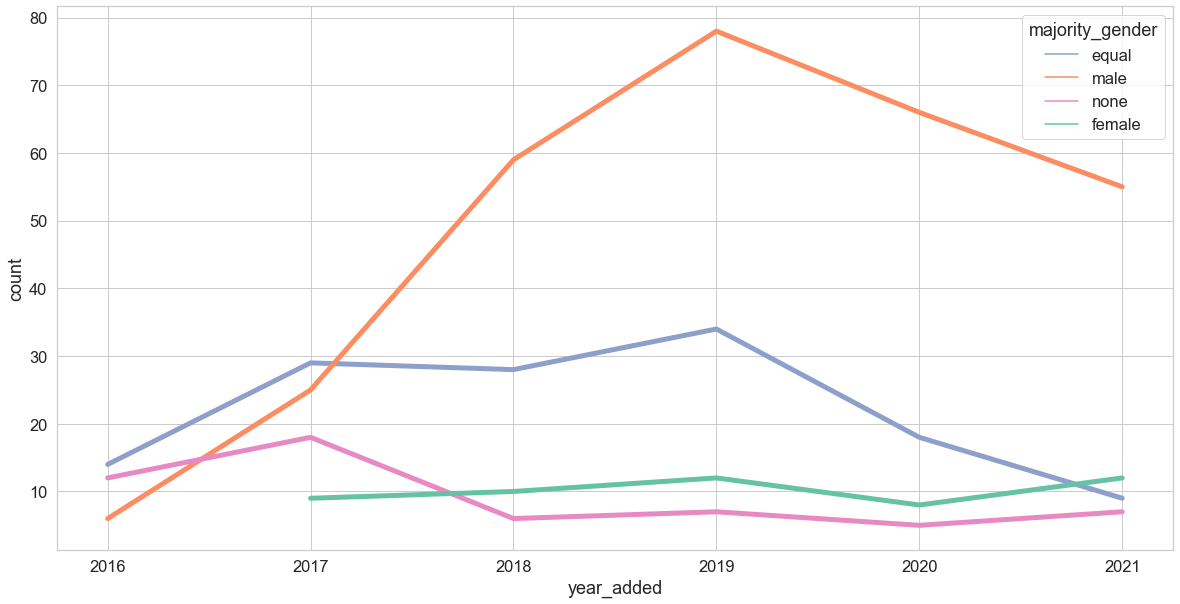

In [123]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year_added', y = 'count', hue = 'majority_gender', data = cast_by_country_year[cast_by_country_year['country'] == "United Kingdom"], lw = 5, palette = qual_pal)

<AxesSubplot:xlabel='year_added', ylabel='count'>

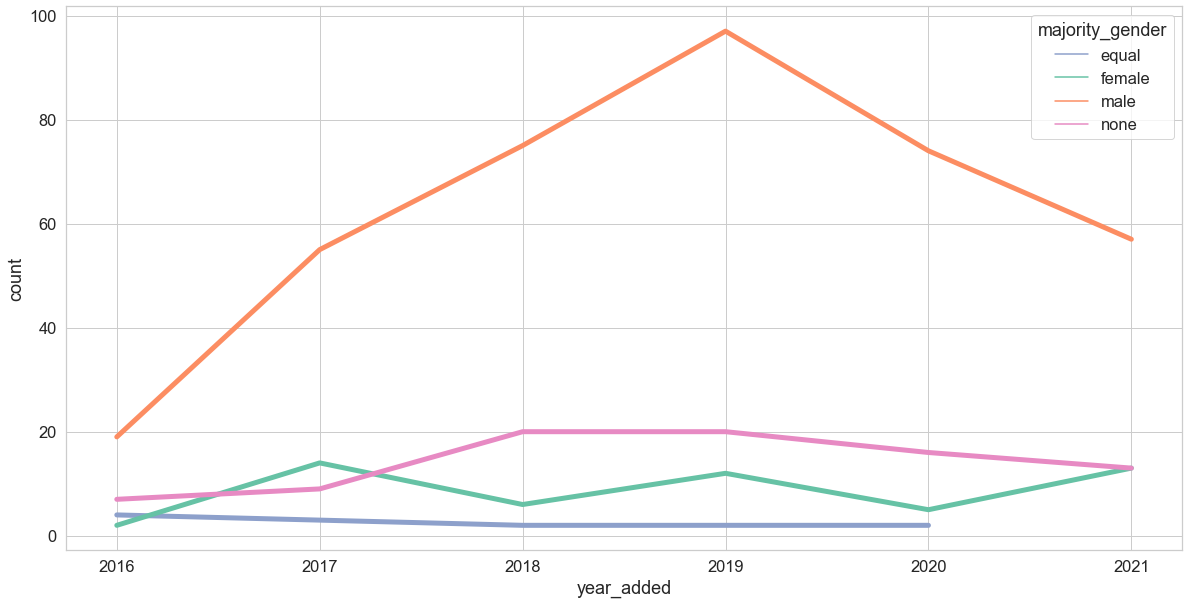

In [124]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year_added', y = 'count', hue = 'majority_gender', data = dir_by_country_year[dir_by_country_year['country'] == "United Kingdom"], lw = 5, palette = qual_pal)

<AxesSubplot:xlabel='year_added', ylabel='count'>

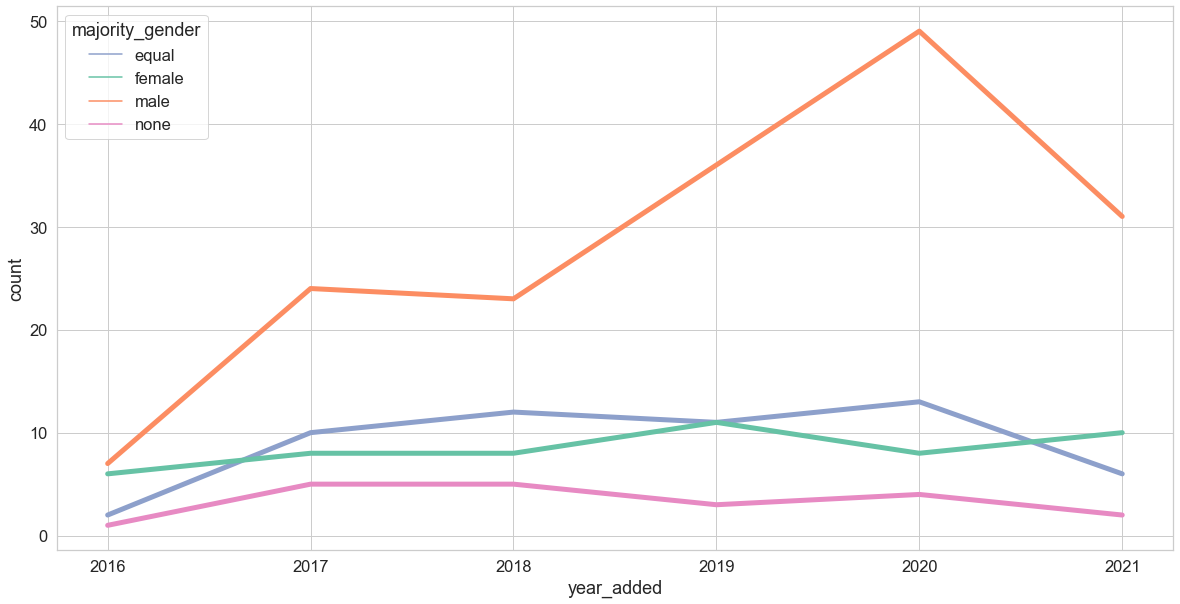

In [125]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year_added', y = 'count', hue = 'majority_gender', data = cast_by_country_year[cast_by_country_year['country'] == "France"], lw = 5, palette = qual_pal)

<AxesSubplot:xlabel='year_added', ylabel='count'>

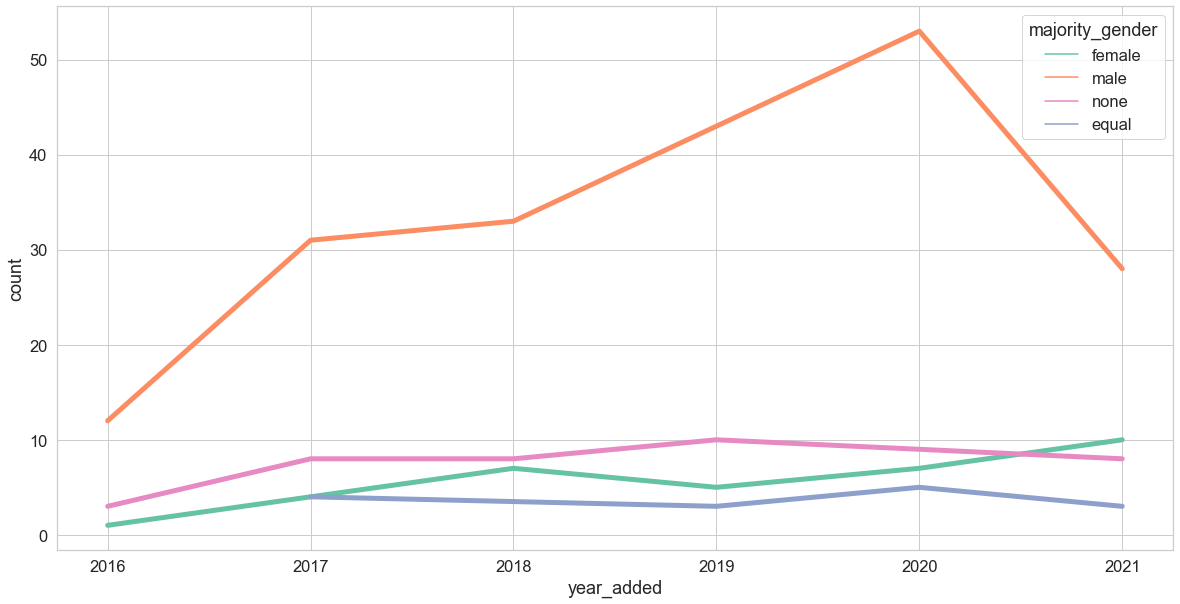

In [126]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year_added', y = 'count', hue = 'majority_gender', data = dir_by_country_year[dir_by_country_year['country'] == "France"], lw = 5, palette = qual_pal)

<AxesSubplot:xlabel='year_added', ylabel='count'>

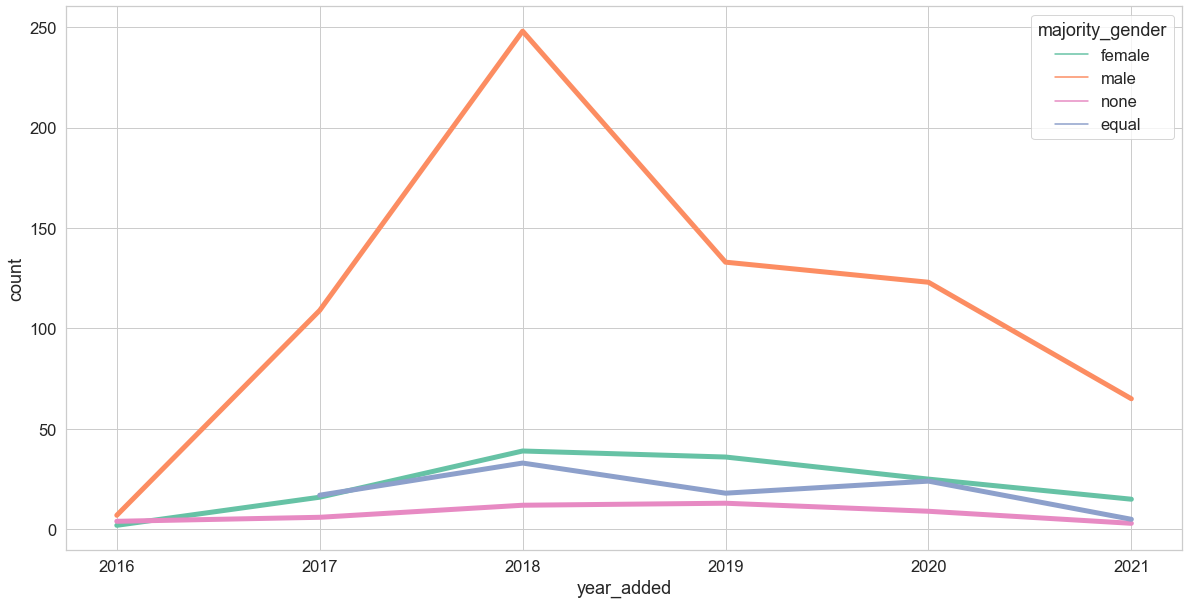

In [127]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year_added', y = 'count', hue = 'majority_gender', data = cast_by_country_year[cast_by_country_year['country'] == "India"], lw = 5, palette = qual_pal)

<AxesSubplot:xlabel='year_added', ylabel='count'>

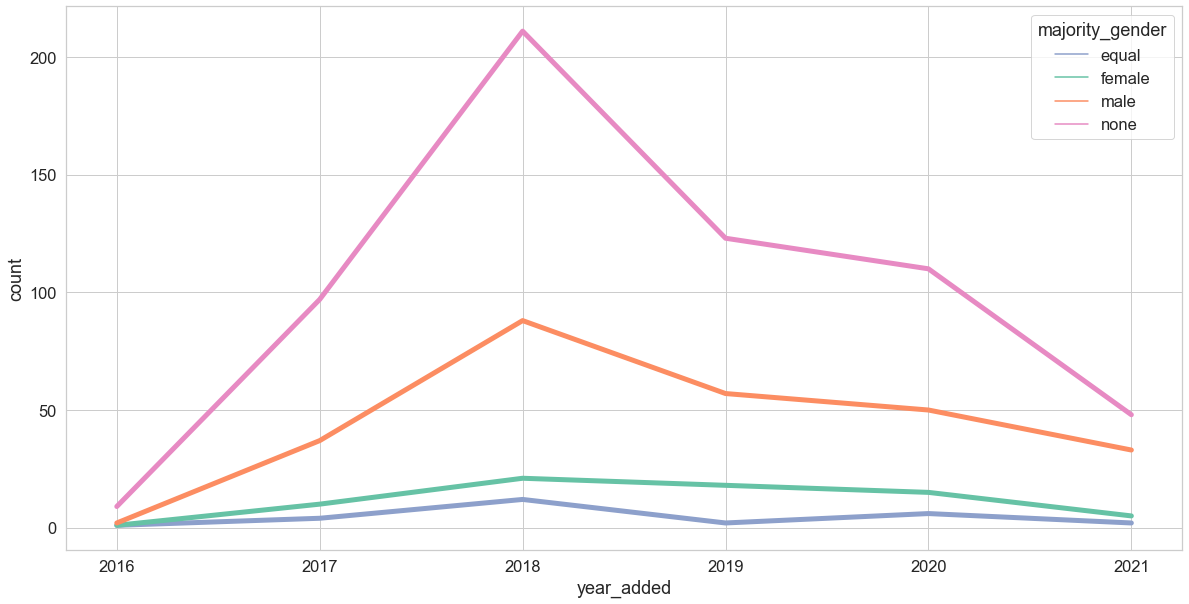

In [128]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year_added', y = 'count', hue = 'majority_gender', data = dir_by_country_year[dir_by_country_year['country'] == "India"], lw = 5, palette = qual_pal)

In [152]:
# cast_ratio
temp_list = []
for country in films_by_country.keys():
    grouped_by_country = films_rating.iloc[films_by_country[country]]
    grouped_by_year_ratio = grouped_by_country.groupby(['year_added'])['cast_ratio'].median()
    year_index = list(grouped_by_year_ratio.index)
    grouped_by_year_ratio_list = list(grouped_by_year_ratio)
    for i, value in enumerate(grouped_by_year_ratio_list):
       row_value = (country, year_index[i], value * 100)
       temp_list.append(row_value)
ratio_by_country_year = pd.DataFrame(temp_list, columns = ['country', 'year_added', 'cast_ratio'])
ratio_by_country_year.head(10)

country  year_added  cast_ratio
0            Montenegro        2016   40.000000
1  United Arab Emirates        2016   16.666667
2  United Arab Emirates        2017   10.000000
3  United Arab Emirates        2018   22.222222
4  United Arab Emirates        2019   25.000000
5  United Arab Emirates        2020   31.666667
6  United Arab Emirates        2021   50.000000
7           Afghanistan        2017    0.000000
8               Somalia        2018   30.000000
9                Kuwait        2020   25.000000

<AxesSubplot:xlabel='year_added', ylabel='cast_ratio'>

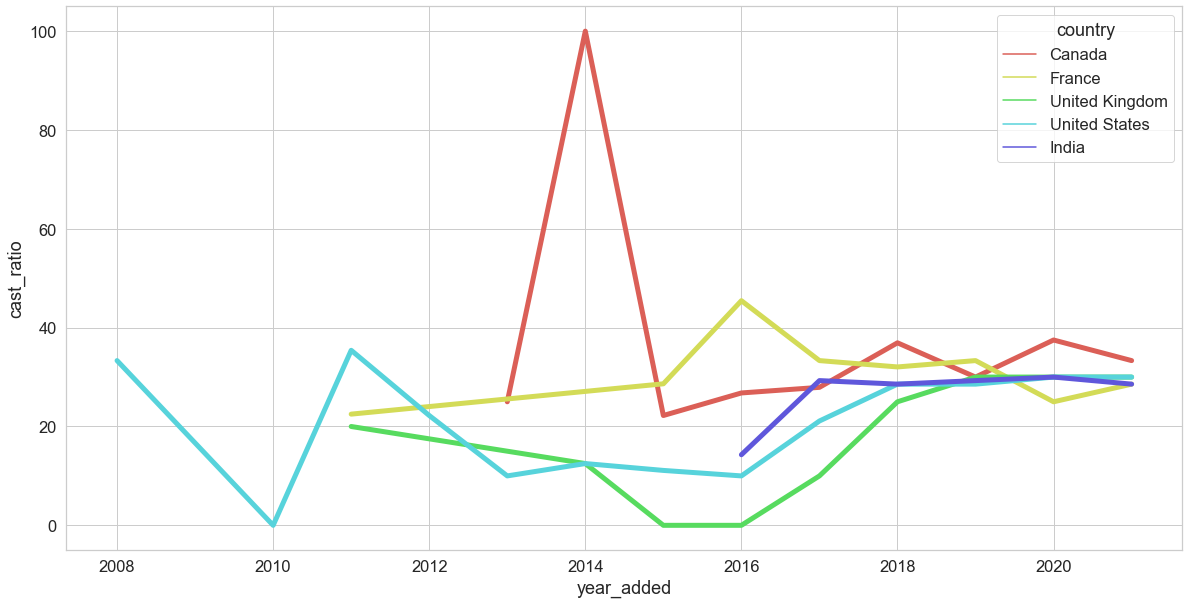

In [153]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year_added', y = 'cast_ratio', hue = 'country', data = ratio_by_country_year.loc[ratio_by_country_year['country'].isin(['United States', 'India', 'United Kingdom', 'Canada', 'France'])], lw = 5)

In [150]:
temp_list = []
for country in films_by_country.keys():
    grouped_by_country = films_rating.iloc[films_by_country[country]]
    year_index = sorted(pd.unique(grouped_by_country['year_added']))
    for year in year_index:
        grouped_by_country_cum = grouped_by_country[grouped_by_country['year_added'] <= year]
        ratio = grouped_by_country_cum['cast_ratio'].median()
        row_value = (country, year, ratio * 100)
        temp_list.append(row_value)
ratio_by_country_year_cum = pd.DataFrame(temp_list, columns = ['country', 'year', 'cast_ratio'])
ratio_by_country_year_cum.head(20)

country  year  cast_ratio
0             Montenegro  2016   40.000000
1   United Arab Emirates  2016   16.666667
2   United Arab Emirates  2017   16.666667
3   United Arab Emirates  2018   20.000000
4   United Arab Emirates  2019   22.222222
5   United Arab Emirates  2020   25.000000
6   United Arab Emirates  2021   25.000000
7            Afghanistan  2017    0.000000
8                Somalia  2018   30.000000
9                 Kuwait  2020   25.000000
10                Kuwait  2021   20.000000
11          Burkina Faso  2021   37.500000
12             Hong Kong  2016    4.545455
13             Hong Kong  2017    9.545455
14             Hong Kong  2018   20.000000
15             Hong Kong  2019   19.090909
16             Hong Kong  2020   18.181818
17             Hong Kong  2021   18.181818
18                Panama  2017    0.000000
19       United Kingdom,  2014   12.500000

<AxesSubplot:xlabel='year', ylabel='cast_ratio'>

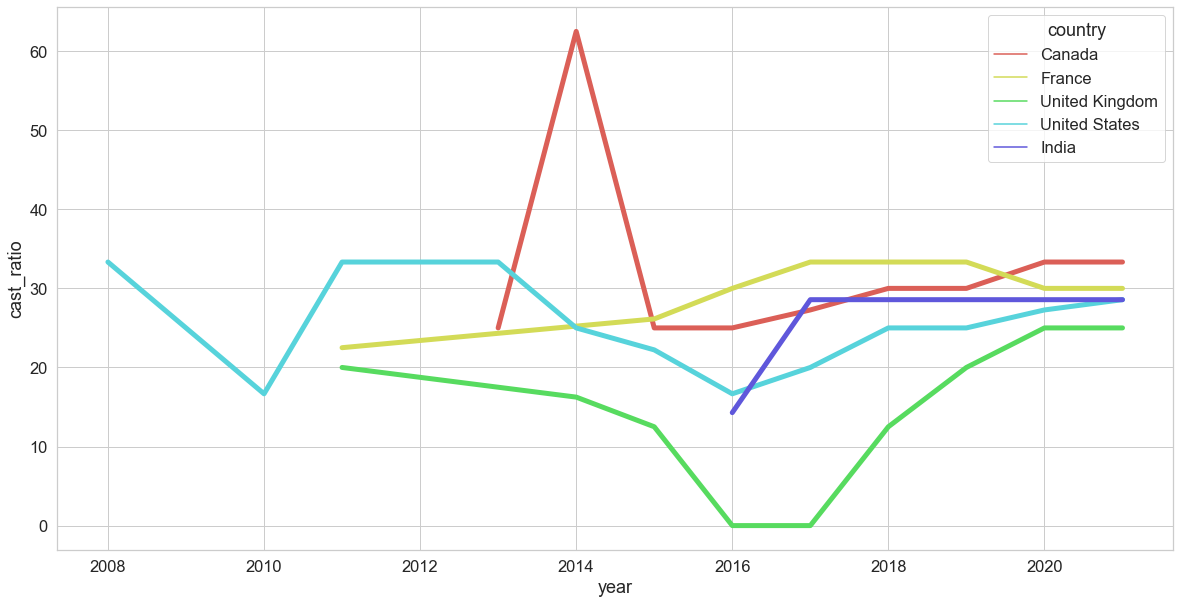

In [151]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(x = 'year', y = 'cast_ratio', hue = 'country', data = ratio_by_country_year_cum.loc[ratio_by_country_year_cum['country'].isin(['United States', 'India', 'United Kingdom', 'Canada', 'France'])], lw = 5)

## Text Analysis of Descriptions

In [75]:
nlp = spacy.load("en_core_web_sm")

### How much more likely would a word appear in a descrption of a female-majority film versus a male-majority film.

In [76]:
counts = defaultdict(lambda: defaultdict(lambda: 0))
for i, row in films_rating.iterrows():
    if row['cast_majority'] == "female" or row['cast_majority'] == "male":
        cast_majority = row['cast_majority']

        doc = nlp(row['description'])
        
        for token in doc:
            counts[cast_majority][token.lemma_] += 1

In [77]:
total_count = {key:sum(list(counts[key].values())) for key in counts.keys() if key != '' and key != float('nan')}
total_count

{'female': 25823, 'male': 92261}

In [78]:
by_pos_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0)))
for i, row in films_rating.iterrows():
    if row['cast_majority'] == "female" or row['cast_majority'] == "male":
        cast_majority = row['cast_majority']

        doc = nlp(row['description'])
        for token in doc:
            by_pos_counts[cast_majority][token.pos_][token.lemma_] += 1

In [79]:
all_pos_words = defaultdict(lambda: set())
for gender in ['male', 'female']:
    for pos in by_pos_counts[gender].keys():
        all_pos_words[pos].update(set(by_pos_counts[gender][pos].keys()))

In [80]:
norm = 92261 / 25823
pos_probs = defaultdict(lambda: defaultdict())
for pos in all_pos_words.keys():
    for word in all_pos_words[pos]:
        male_count = by_pos_counts['male'][pos][word]
        fem_count = by_pos_counts['female'][pos][word] * norm
        if fem_count > float(0):
            if male_count > float(0):
                male_prob = male_count / (male_count + fem_count)
                fem_prob = fem_count / (male_count + fem_count)
                prob = (max(male_prob, fem_prob) / (min(male_prob, fem_prob))) * (2 * int(male_prob > fem_prob) - 1)
                pos_probs[pos][word] = prob

In [81]:
pos_probs

defaultdict(<function __main__.<lambda>()>,
            {'ADP': defaultdict(None,
                         {'like': -1.071846803237424,
                          'along': -1.11650708670565,
                          'at': -1.3797485949533235,
                          'before': -1.948812369522589,
                          'to': -1.0208064792737372,
                          'during': 1.4594303118327354,
                          'over': 1.0635848299931716,
                          'off': 1.0226777211472804,
                          'above': 1.1195629789401806,
                          'in': 1.0136583728242177,
                          'past': 1.1195629789401806,
                          'out': -1.115325597725009,
                          'without': -1.2992082463483927,
                          'next': -3.57282267745808,
                          'into': -1.0530424733560655,
                          'after': -1.1150847846843688,
                          'with': -1.263911837343

In [82]:
for pos in pos_probs.keys():
    pos_probs[pos] = sorted([(word, pos_probs[pos][word]) for word in pos_probs[pos]], key = lambda f: f[1])

In [83]:
pos_probs

defaultdict(<function __main__.<lambda>()>,
            {'ADP': [('next', -3.57282267745808),
              ('until', -2.143693606474848),
              ('before', -1.948812369522589),
              ('en', -1.7864113387290397),
              ('via', -1.7864113387290397),
              ('about', -1.5376705194123381),
              ('beyond', -1.5312097189106055),
              ('through', -1.4533515976100664),
              ('at', -1.3797485949533235),
              ('outside', -1.33980850404678),
              ('without', -1.2992082463483927),
              ('with', -1.2639118373435516),
              ('inside', -1.2609962391028517),
              ('around', -1.232007819813131),
              ('between', -1.1451354735442563),
              ('along', -1.11650708670565),
              ('out', -1.115325597725009),
              ('after', -1.1150847846843688),
              ('like', -1.071846803237424),
              ('into', -1.0530424733560655),
              ('to', -1.0208064792737372),

In [84]:
for word, value in pos_probs['VERB'][:20]:
    print(word)

mend
discuss
conflict
smoke
cook
rent
wonder
grapple
divorce
hop
hang
escalate
accord
retreat
wound
split
fool
pick
disturb
adjust


In [85]:
for word, value in pos_probs['ADJ'][:20]:
    print(word)

willed
lesbian
ailing
terrible
favorite
online
bohemian
swanky
alarming
uncomfortable
grisly
chilling
excited
oddball
helpful
alluring
tired
seventh
ago
horrifying


In [86]:
for word, value in pos_probs['ADV'][:20]:
    print(word)

rather
close
deeply
abroad
potentially
strictly
magically
continually
possibly
slow
perfectly
fiercely
afloat
drunkenly
rascally
before
profoundly
otherwise
bravely
emotionally


In [87]:
for word, value in pos_probs['NOUN'][:20]:
    print(word)

grapple
present
niece
queen
poetry
stress
villa
editor
cooking
verge
dj
sweetheart
breakup
transfer
fairy
aunt
fiancé
gender
month
webcam


In [88]:
for word, value in pos_probs['NOUN'][:20]:
    print(word)

grapple
present
niece
queen
poetry
stress
villa
editor
cooking
verge
dj
sweetheart
breakup
transfer
fairy
aunt
fiancé
gender
month
webcam


In [89]:
for row in pos_probs['NOUN'][10:20][::-1]:
    print(row)

('webcam', -7.14564535491616)
('month', -7.14564535491616)
('gender', -7.14564535491616)
('fiancé', -7.1456453549161605)
('aunt', -7.1456453549161605)
('fairy', -8.336586247402186)
('transfer', -8.932056693645197)
('breakup', -8.932056693645197)
('sweetheart', -10.71846803237424)
('dj', -10.71846803237424)


In [90]:
len(pos_probs['NOUN']) - 10

1395

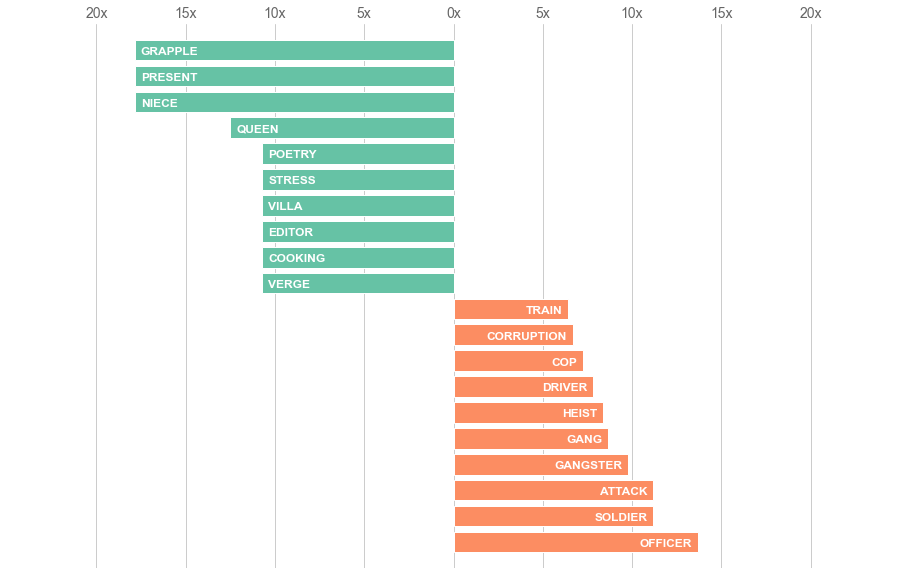

In [91]:
fig, ax = plt.subplots(figsize = (16, 10))
pos = 'NOUN'
# plotting the bars
fem_bars = ax.barh(y = [i for i in range (1, 11)], width = [row[1] for row in pos_probs[pos][:10][::-1]], 
                   color = '#66c2a5', zorder = 2, label = 'female')

male_bars = ax.barh(y = [i for i in range (-9, 1)], width = [row[1] for row in pos_probs[pos][len(pos_probs[pos]) - 10:][::-1]], 
                   color = '#fc8d62', zorder = 2, label = 'male')

# x axis
plt.xlim(-25, 25.01) #.01 so that final right gridline will appear
plt.xticks(ticks = list(range(-20, 21, 5)), labels = [str(abs(i)) + 'x' for i in range(-20, 21, 5)],
           fontsize = 14, color = (0.4, 0.4, 0.4))

# y axis
plt.ylim(-10, 11)
male_words = [i[0] for i in pos_probs[pos][len(pos_probs[pos]) - 10:]][::-1]
female_words = [i[0] for i in pos_probs[pos][:10]][::-1]
ax.axes.get_yaxis().set_visible(False)

# gridlines
ax.xaxis.grid(True, linestyle='-')

# putting x labels at the top
ax.xaxis.tick_top()

# make ticks disappear
ax.tick_params(axis = u'both', which = u'both', length = 0)

# remove outline box
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# add words to each bar
for i, bar in enumerate(fem_bars):
        width = bar.get_width()
        y = bar.get_y()
        ax.annotate('{}'.format(female_words[i].upper()),
                    xy=(width + 0.35, y + 0.35),
                    xytext=(0, 0),  # 3 points vertical offset
                    textcoords="offset points",
                    fontsize = 12,
                    ha='left', va='center', color='#ffffff', weight='bold')

for i, bar in enumerate(male_bars):
        width = bar.get_width()
        y = bar.get_y()
        ax.annotate('{}'.format(male_words[i].upper()),
                    xy=(width - 0.35, y + 0.35),
                    xytext=(0, 0),  # 3 points vertical offset
                    textcoords="offset points",
                    fontsize = 12,
                    ha='right', va='center', color='#ffffff', weight='bold')

plt.show() 

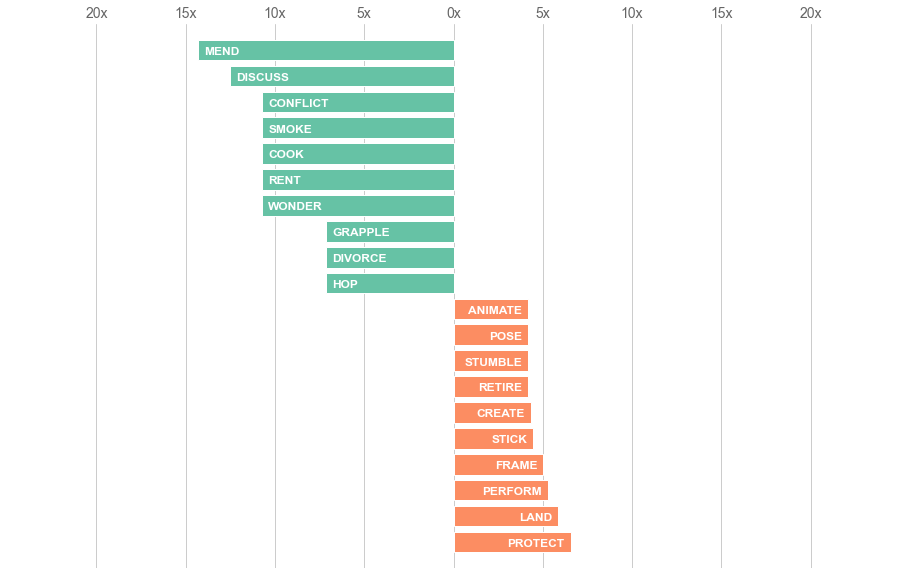

In [92]:
fig, ax = plt.subplots(figsize = (16, 10))
pos = 'VERB'
# plotting the bars
fem_bars = ax.barh(y = [i for i in range (1, 11)], width = [row[1] for row in pos_probs[pos][:10][::-1]], 
                   color = '#66c2a5', zorder = 2, label = 'female')

male_bars = ax.barh(y = [i for i in range (-9, 1)], width = [row[1] for row in pos_probs[pos][len(pos_probs[pos]) - 10:][::-1]], 
                   color = '#fc8d62', zorder = 2, label = 'male')

# x axis
plt.xlim(-25, 25.01) #.01 so that final right gridline will appear
plt.xticks(ticks = list(range(-20, 21, 5)), labels = [str(abs(i)) + 'x' for i in range(-20, 21, 5)],
           fontsize = 14, color = (0.4, 0.4, 0.4))

# y axis
plt.ylim(-10, 11)
male_words = [i[0] for i in pos_probs[pos][len(pos_probs[pos]) - 10:]][::-1]
female_words = [i[0] for i in pos_probs[pos][:10]][::-1]
ax.axes.get_yaxis().set_visible(False)

# gridlines
ax.xaxis.grid(True, linestyle='-')

# putting x labels at the top
ax.xaxis.tick_top()

# make ticks disappear
ax.tick_params(axis = u'both', which = u'both', length = 0)

# remove outline box
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# add words to each bar
for i, bar in enumerate(fem_bars):
        width = bar.get_width()
        y = bar.get_y()
        ax.annotate('{}'.format(female_words[i].upper()),
                    xy=(width + 0.35, y + 0.35),
                    xytext=(0, 0),  # 3 points vertical offset
                    textcoords="offset points",
                    fontsize = 12,
                    ha='left', va='center', color='#ffffff', weight='bold')

for i, bar in enumerate(male_bars):
        width = bar.get_width()
        y = bar.get_y()
        ax.annotate('{}'.format(male_words[i].upper()),
                    xy=(width - 0.35, y + 0.35),
                    xytext=(0, 0),  # 3 points vertical offset
                    textcoords="offset points",
                    fontsize = 12,
                    ha='right', va='center', color='#ffffff', weight='bold')

plt.show() 

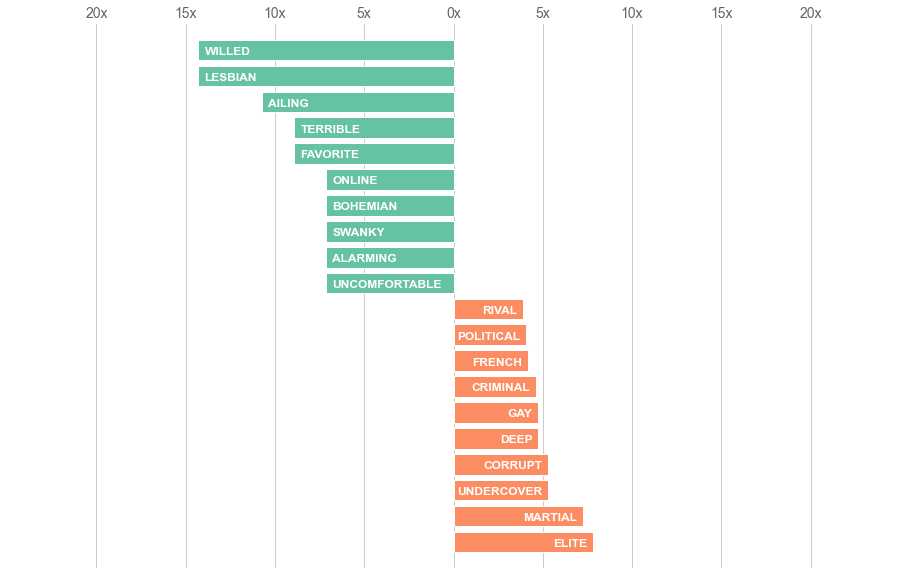

In [93]:
fig, ax = plt.subplots(figsize = (16, 10))
pos = 'ADJ'
# plotting the bars
fem_bars = ax.barh(y = [i for i in range (1, 11)], width = [row[1] for row in pos_probs[pos][:10][::-1]], 
                   color = '#66c2a5', zorder = 2, label = 'female')

male_bars = ax.barh(y = [i for i in range (-9, 1)], width = [row[1] for row in pos_probs[pos][len(pos_probs[pos]) - 10:][::-1]], 
                   color = '#fc8d62', zorder = 2, label = 'male')

# x axis
plt.xlim(-25, 25.01) #.01 so that final right gridline will appear
plt.xticks(ticks = list(range(-20, 21, 5)), labels = [str(abs(i)) + 'x' for i in range(-20, 21, 5)],
           fontsize = 14, color = (0.4, 0.4, 0.4))

# y axis
plt.ylim(-10, 11)
male_words = [i[0] for i in pos_probs[pos][len(pos_probs[pos]) - 10:]][::-1]
female_words = [i[0] for i in pos_probs[pos][:10]][::-1]
ax.axes.get_yaxis().set_visible(False)

# gridlines
ax.xaxis.grid(True, linestyle='-')

# putting x labels at the top
ax.xaxis.tick_top()

# make ticks disappear
ax.tick_params(axis = u'both', which = u'both', length = 0)

# remove outline box
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# add words to each bar
for i, bar in enumerate(fem_bars):
        width = bar.get_width()
        y = bar.get_y()
        ax.annotate('{}'.format(female_words[i].upper()),
                    xy=(width + 0.35, y + 0.35),
                    xytext=(0, 0),  # 3 points vertical offset
                    textcoords="offset points",
                    fontsize = 12,
                    ha='left', va='center', color='#ffffff', weight='bold')

for i, bar in enumerate(male_bars):
        width = bar.get_width()
        y = bar.get_y()
        ax.annotate('{}'.format(male_words[i].upper()),
                    xy=(width - 0.35, y + 0.35),
                    xytext=(0, 0),  # 3 points vertical offset
                    textcoords="offset points",
                    fontsize = 12,
                    ha='right', va='center', color='#ffffff', weight='bold')

plt.show() 

In [94]:
path_to_mallet = '/Users/huongngo/mallet-2.0.8/bin/mallet'
output_directory_path_female = '/Users/huongngo/Desktop/PERSONAL PROJECTS/streaming_analysis/data/topic_modelling/films_analysis/female'
output_directory_path_male = '/Users/huongngo/Desktop/PERSONAL PROJECTS/streaming_analysis/data/topic_modelling/films_analysis/male'

In [95]:
def plt_wc(words):
    fig, ax = plt.subplots(figsize = (10, 10))
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'white', width = 5000, height = 5000, colormap = "RdPu").generate(words)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [96]:
training_data_male = []
training_data_female = []
for i, row in films_rating.iterrows():
    text = row['description']
    processed_text = little_mallet_wrapper.process_string(text, numbers = 'remove')

    if row['cast_majority'] == "female":
        training_data_female.append(processed_text)
    elif row['cast_majority'] == "male":
        training_data_male.append(processed_text)

In [97]:
print('Training Data Text (Female Cast Majority)')
little_mallet_wrapper.print_dataset_stats(training_data_female)
print("")
print('Training Data Text (Male Cast Majority)')
little_mallet_wrapper.print_dataset_stats(training_data_male)

Training Data Text (Female Cast Majority)
Number of Documents: 931
Mean Number of Words per Document: 14.3
Vocabulary Size: 4887

Training Data Text (Male Cast Majority)
Number of Documents: 3335
Mean Number of Words per Document: 14.5
Vocabulary Size: 10692


In [98]:
num_topics = 5

In [99]:
little_mallet_wrapper.quick_train_topic_model(path_to_mallet, output_directory_path_female, num_topics, training_data_female)

Importing data...
Complete
Training topic model...


Mallet LDA: 5 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 26
total tokens: 13344
<10> LL/token: -9.50118
<20> LL/token: -9.41699
<30> LL/token: -9.36512
<40> LL/token: -9.35853

0	1	love must woman couple daughter life young mother son marriage secret becomes married childhood sets true child together way trip 
1	1	family find father new women lives love life get man day take determined christmas young keep writer starts long boyfriend 
2	1	young girl man teen friends one life two back tries relationship help world soon single turns mother girlfriend save falls 
3	1	new home school high old takes year past begins gets mysterious sister college make romance town returns boy night teenage 
4	1	woman finds friend three best two years husband student four wife first meets friends bond chance struggling become social navigate 

<50> LL/token: -9.35693
<60> LL/token: -9.32901
<70> LL/token: -9.33016
<80> LL/token: -9.33782
<90> LL/token: -9.32887

0	1	love life woman must d

Complete


[beta: 0.44495] 
<940> LL/token: -8.8234

0	2.28323	young new woman life family love man home two friends school girl finds must mother teen old high friend couple 
1	0.29521	much issues law meets invents fighting call armed finally starts outside hong teach crimes tracks fact formed shady top ceo 
2	0.32989	show play christmas stars holiday discuss class cast classic identity magic fairy business drama members summer family daughters bus santa 
3	0.26697	half professor enters head company blind cope hospital try island travel white grow weddings live appears across retreat planner reality 
4	0.28029	search monster abandoned queen princess earth ambitious fiancé good earn determined hero teens quest ana clawdeen widow paris writer teenager 

[beta: 0.45585] 
<950> LL/token: -8.83587
[beta: 0.44561] 
<960> LL/token: -8.84231
[beta: 0.44426] 
<970> LL/token: -8.83171
[beta: 0.45283] 
<980> LL/token: -8.82925
[beta: 0.45075] 
<990> LL/token: -8.8415

0	2.23155	young new woman life family 

([['young',
   'new',
   'woman',
   'life',
   'family',
   'love',
   'man',
   'home',
   'friends',
   'school',
   'two',
   'girl',
   'must',
   'mother',
   'finds',
   'teen',
   'old',
   'high',
   'friend',
   'couple'],
  ['world',
   'movie',
   'navigate',
   'princess',
   'lawyer',
   'class',
   'war',
   'club',
   'competition',
   'hired',
   'holiday',
   'sex',
   'places',
   'documentary',
   'horse',
   'around',
   'shopkins',
   'cooking',
   'poetry',
   'celebrity'],
  ['drama',
   'stars',
   'reporter',
   'big',
   'monster',
   'season',
   'show',
   'mystery',
   'drug',
   'retreat',
   'powers',
   'sends',
   'discuss',
   'hit',
   'cast',
   'consequences',
   'ceo',
   'spend',
   'extraordinary',
   'black'],
  ['group',
   'people',
   'different',
   'body',
   'blind',
   'london',
   'death',
   'perfect',
   'inuyasha',
   'prove',
   'determined',
   'hero',
   'wolf',
   'mix',
   'elaborate',
   'place',
   'action',
   'across',
   'l

In [100]:
little_mallet_wrapper.quick_train_topic_model(path_to_mallet, output_directory_path_male, num_topics, training_data_male)

Importing data...
Complete
Training topic model...


Mallet LDA: 5 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 28
total tokens: 48350
<10> LL/token: -9.60978
<20> LL/token: -9.49013
<30> LL/token: -9.43291
<40> LL/token: -9.40462

0	1	three home two town family lives young father friends find years small mother returns time becomes woman trip run drug 
1	1	must crime team take secret cop agent save drama rescue world killer battle discovers murder soon war officer detective game 
2	1	new young life school true man story high daughter world group past tries based four student help friends fight city 
3	1	life one woman love man girl two new find family brother finds young friend boy day gang sets revenge death 
4	1	son father old help man couple mission begins woman takes mysterious must wife year goes marriage get becomes special stop 

<50> LL/token: -9.37654
<60> LL/token: -9.36676
<70> LL/token: -9.35054
<80> LL/token: -9.33848
<90> LL/token: -9.31382

0	1	two family three town find friends father mother home lives y

Complete


([['save',
   'christmas',
   'friends',
   'find',
   'world',
   'new',
   'way',
   'evil',
   'get',
   'holiday',
   'rescue',
   'santa',
   'city',
   'must',
   'back',
   'quest',
   'angeles',
   'bheem',
   'mission',
   'three'],
  ['war',
   'group',
   'must',
   'team',
   'agent',
   'mission',
   'world',
   'cop',
   'fight',
   'forces',
   'take',
   'police',
   'battle',
   'two',
   'crime',
   'army',
   'revenge',
   'terrorist',
   'government',
   'earth'],
  ['story',
   'based',
   'drama',
   'film',
   'comedy',
   'true',
   'life',
   'follows',
   'tale',
   'documentary',
   'biopic',
   'live',
   'events',
   'stories',
   'india',
   'series',
   'star',
   'first',
   'stars',
   'animated'],
  ['young',
   'man',
   'family',
   'woman',
   'life',
   'two',
   'father',
   'new',
   'find',
   'son',
   'one',
   'old',
   'love',
   'home',
   'help',
   'must',
   'murder',
   'three',
   'finds',
   'daughter'],
  ['school',
   'high',
   'lo

In [101]:
# female cast majority 
path_to_topic_keys = '/Users/huongngo/Desktop/PERSONAL PROJECTS/streaming_analysis/data/topic_modelling/films_analysis/female/mallet.topic_keys.5'
topics = little_mallet_wrapper.load_topic_keys(path_to_topic_keys)

for number, topic in enumerate(topics):
    print(f"✨Topic {number}✨\n\n{topic}\n")

✨Topic 0✨

['young', 'new', 'woman', 'life', 'family', 'love', 'man', 'home', 'friends', 'school', 'two', 'girl', 'must', 'mother', 'finds', 'teen', 'old', 'high', 'friend', 'couple']

✨Topic 1✨

['world', 'movie', 'navigate', 'princess', 'lawyer', 'class', 'war', 'club', 'competition', 'hired', 'holiday', 'sex', 'places', 'documentary', 'horse', 'around', 'shopkins', 'cooking', 'poetry', 'celebrity']

✨Topic 2✨

['drama', 'stars', 'reporter', 'big', 'monster', 'season', 'show', 'mystery', 'drug', 'retreat', 'powers', 'sends', 'discuss', 'hit', 'cast', 'consequences', 'ceo', 'spend', 'extraordinary', 'black']

✨Topic 3✨

['group', 'people', 'different', 'body', 'blind', 'london', 'death', 'perfect', 'inuyasha', 'prove', 'determined', 'hero', 'wolf', 'mix', 'elaborate', 'place', 'action', 'across', 'leads', 'join']

✨Topic 4✨

['stop', 'magic', 'park', 'online', 'little', 'leave', 'play', 'ghosts', 'return', 'earth', 'maya', 'winning', 'spirited', 'destroy', 'set', 'chaotic', 'holiday',

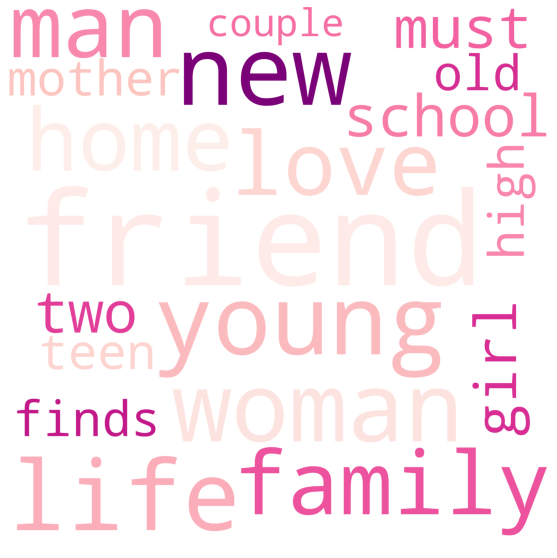

In [102]:
words = ' '.join(topics[0])
plt_wc(words)

In [103]:
# male cast majority 
path_to_topic_keys = '/Users/huongngo/Desktop/PERSONAL PROJECTS/streaming_analysis/data/topic_modelling/films_analysis/male/mallet.topic_keys.5'
topics = little_mallet_wrapper.load_topic_keys(path_to_topic_keys)

for number, topic in enumerate(topics):
    print(f"✨Topic {number}✨\n\n{topic}\n")

✨Topic 0✨

['save', 'christmas', 'friends', 'find', 'world', 'new', 'way', 'evil', 'get', 'holiday', 'rescue', 'santa', 'city', 'must', 'back', 'quest', 'angeles', 'bheem', 'mission', 'three']

✨Topic 1✨

['war', 'group', 'must', 'team', 'agent', 'mission', 'world', 'cop', 'fight', 'forces', 'take', 'police', 'battle', 'two', 'crime', 'army', 'revenge', 'terrorist', 'government', 'earth']

✨Topic 2✨

['story', 'based', 'drama', 'film', 'comedy', 'true', 'life', 'follows', 'tale', 'documentary', 'biopic', 'live', 'events', 'stories', 'india', 'series', 'star', 'first', 'stars', 'animated']

✨Topic 3✨

['young', 'man', 'family', 'woman', 'life', 'two', 'father', 'new', 'find', 'son', 'one', 'old', 'love', 'home', 'help', 'must', 'murder', 'three', 'finds', 'daughter']

✨Topic 4✨

['school', 'high', 'love', 'life', 'new', 'teen', 'student', 'town', 'finds', 'gets', 'college', 'indian', 'party', 'falls', 'bond', 'career', 'girl', 'becomes', 'teacher', 'social']



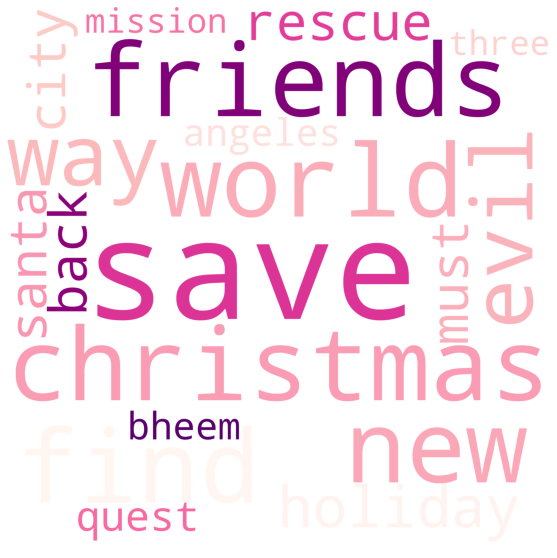

In [104]:
words = ' '.join(topics[0])
plt_wc(words)

In [105]:
top_10 = ['United States', 'India', 'United Kingdom', 'Canada', 'France', 'Germany', 'Spain', 'Japan', 'China', 'Mexico']
top_10_films_country = {key:value for key, value in films_by_country.items() if key in top_10}
top_10_films_country

{'United Kingdom': [2,
  54,
  63,
  65,
  68,
  78,
  83,
  93,
  113,
  122,
  145,
  149,
  179,
  180,
  181,
  183,
  193,
  204,
  214,
  221,
  222,
  231,
  249,
  256,
  363,
  367,
  373,
  375,
  377,
  385,
  391,
  393,
  396,
  397,
  453,
  471,
  472,
  520,
  524,
  570,
  587,
  598,
  599,
  600,
  610,
  612,
  615,
  625,
  665,
  670,
  682,
  684,
  715,
  723,
  729,
  751,
  756,
  757,
  758,
  760,
  761,
  767,
  768,
  776,
  786,
  788,
  792,
  796,
  811,
  826,
  847,
  850,
  852,
  855,
  866,
  893,
  895,
  901,
  913,
  917,
  958,
  963,
  989,
  991,
  993,
  1007,
  1013,
  1052,
  1057,
  1073,
  1074,
  1103,
  1146,
  1152,
  1174,
  1178,
  1179,
  1192,
  1196,
  1198,
  1201,
  1213,
  1228,
  1231,
  1250,
  1257,
  1277,
  1297,
  1303,
  1305,
  1312,
  1335,
  1369,
  1382,
  1383,
  1388,
  1391,
  1398,
  1437,
  1442,
  1494,
  1504,
  1510,
  1554,
  1556,
  1558,
  1604,
  1634,
  1675,
  1698,
  1723,
  1740,
  1748,
  1762,
  17

In [106]:
pos_words_country = defaultdict(lambda: defaultdict(lambda: []))
for country, indices in top_10_films_country.items():
    group = films_rating.iloc[indices]
    for desc in group['description']:
        doc = nlp(desc)
        for token in doc:
            pos_words_country[country][token.pos_].append(str(token))
    for pos in pos_words_country[country].keys():
        pos_words_country[country][pos] = " ".join(pos_words_country[country][pos])

In [107]:
pos_words_country['United States']['male']

[]

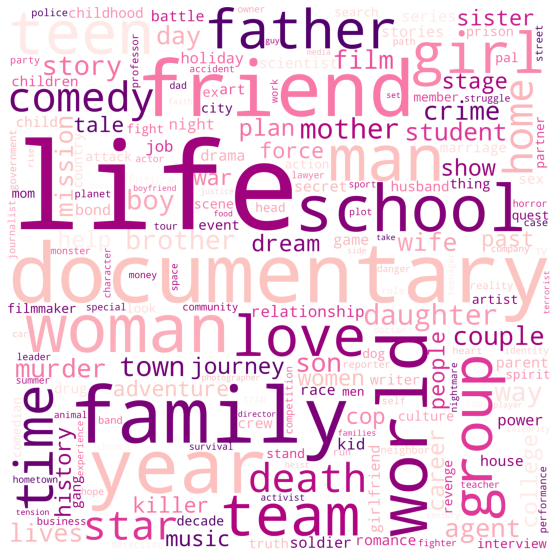

In [108]:
plt_wc(pos_words_country['United States']['NOUN'])

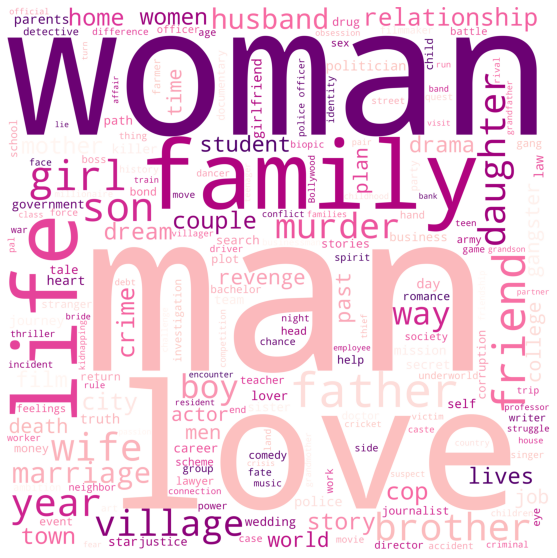

In [109]:
plt_wc(pos_words_country['India']['NOUN'])

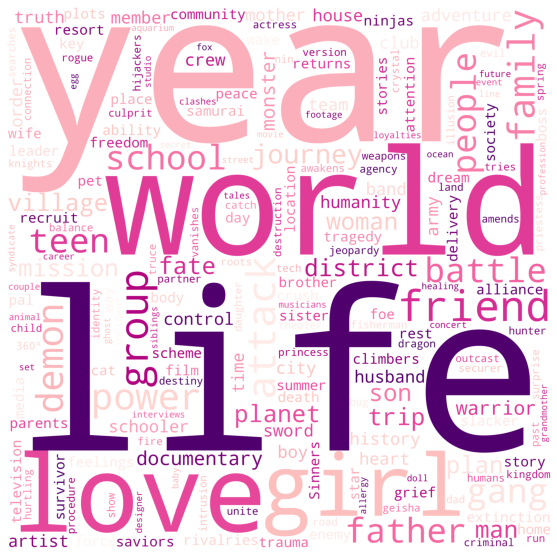

In [110]:
plt_wc(pos_words_country['Japan']['NOUN'])

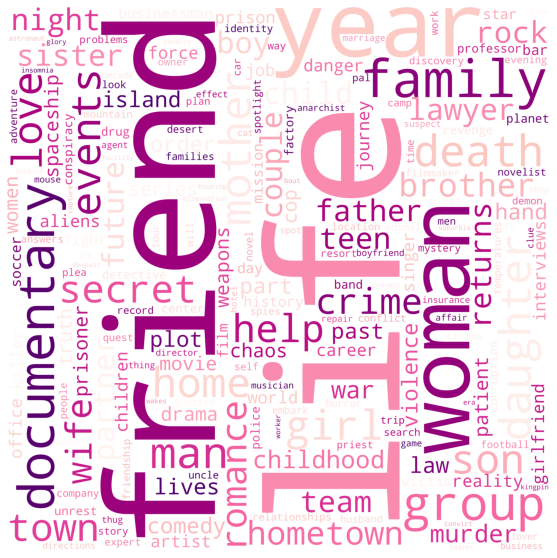

In [111]:
plt_wc(pos_words_country['Spain']['NOUN'])

## Hypothesis Testing

### Does gender of the cast majority affect the rating of a film?

In [112]:
cast_majority_groups = films_rating.groupby(['cast_majority']).groups

In [113]:
fem_rating = list(films_rating['averageRating'].iloc[cast_majority_groups['female']])
male_rating = list(films_rating['averageRating'].iloc[cast_majority_groups['male']])
equal_rating = list(films_rating['averageRating'].iloc[cast_majority_groups['equal']])

#### Stating the hypothesis

#### Checking for normality

In [114]:
def normality_check(data):
    t_stat, p_val = stats.kstest(data, stats.norm.cdf)
    
    print("p value = %.4f" %p_val)
    if p_val < 0.05:
        print("Reject null hypothesis - Data is not normally distributed")
    else:
        print("Fail to reject the null hypothesis - Data is normally distributed")

In [115]:
print("Fem Average Rating")
normality_check(fem_rating)
print("")
print("Male Average Rating")
normality_check(male_rating)
print("")
print("Equal Average Rating")
normality_check(equal_rating)

Fem Average Rating
p value = 0.0000
Reject null hypothesis - Data is not normally distributed

Male Average Rating
p value = 0.0000
Reject null hypothesis - Data is not normally distributed

Equal Average Rating
p value = 0.0000
Reject null hypothesis - Data is not normally distributed


#### Check for variance homogeneity across the groups

In [116]:
def check_variance_homo(group_1, group_2, group_3):
    t_stat, p_val = stats.levene(group_1, group_2, group_3)

    print("p value = %.4f" %p_val)
    if p_val < 0.05:
        print("Reject null hypothesis - The variances of the groups are different")
    else:
        print("Fail to reject the null hypothesis - The variances of the groups are same")

In [117]:
check_variance_homo(fem_rating, male_rating, equal_rating)

p value = 0.0001
Reject null hypothesis - The variances of the groups are different


#### Kruskal Wallis Test

In [118]:
h_stat, p_val = stats.kruskal(fem_rating, male_rating, equal_rating)
print("p value = %.5f" %p_val)
if p_val < 0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject the null hypothesis")

p value = 0.00001
Reject null hypothesis


In [119]:
posthoc = sp.posthoc_mannwhitney([fem_rating, male_rating, equal_rating], p_adjust = 'bonferroni')
groups = ["fem_majority", "male_majority", "equal"]
posthoc.columns = groups
posthoc.index = groups
posthoc.style.applymap(lambda x: "background-color:violet" if x < 0.05 else "background-color: black")